本篇章節開始進行LDA的相關處理，而基本的字詞處理已於之前說過，這裡不再贅述，直接到LDA的操作及結果說明

In [1]:
import time
import re  
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import plotly.express as px
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models
import guidedlda

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# 繪圖設定
plt.rcParams['font.family'] = 'Microsoft YaHei'
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False



d:\anaconda\envs\tf1_env\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


1.載入檔案

In [2]:
df = pd.read_csv('chiikawa_unified_data.csv')
print(df.head())

   system_id dataSource                                       artUrl  \
0          1         YT  https://www.youtube.com/watch?v=3fmZbTHG8us   
1          2         YT  https://www.youtube.com/watch?v=kcilIzr7Bf0   
2          3         YT  https://www.youtube.com/watch?v=6EtTJFbRRaE   
3          4         YT  https://www.youtube.com/watch?v=r4ZtjfGZQaA   
4          5         YT  https://www.youtube.com/watch?v=uFynuUT3mHI   

               artDate                                     artTitle  \
0  2024-07-06 18:46:55                                   小八跳舞 #吉伊卡哇   
1  2024-07-07 04:48:58       【Chiikawa】睡衣派對之歌 / パジャマパーティーズのうた 廣東話歌詞   
2  2024-07-08 07:07:35                【🔴Live直播】開箱華山快閃店！「史努比、吉伊卡哇」萌翻   
3  2024-07-15 03:07:46         【突發LA】迫不及待的盲抽🌟拆熱騰騰剛到的吉伊卡哇卡牌盲包🐺 #森森鈴蘭   
4  2024-07-16 14:27:08  【戰利品開箱LA】笑死 買到沒錢💸 #森森鈴蘭 #吉伊卡哇 #我要記得宣傳演唱會RRR   

                                          artContent  \
0                                         小八跳舞 #吉伊卡哇   
1  【Chiikawa】睡衣派對之歌 / パジャマパー

進行詞彙定義

In [3]:
# 設定jieba的字典和使用者自定義詞典
jieba.set_dictionary('dict/dict.txt.big')  # 使用繁體中文字典

# 新增特定領域詞彙到自定義詞典
custom_words = [
    # 主要名稱
    "Chiikawa", "吉伊卡哇", "ちいかわ", "吉伊", "小可愛", "吉依", "寶寶",
    
    # 主要角色
    "小八貓", "ハチワレ", "Hachiware", "八字瀏海", "小八", "藍色褲頭貓", "哈奇" , "哈吉",
    "兔兔", "うさぎ", "Usagi", "烏薩奇", "兔哥", "537",
    "小桃", "モモンガ", "Momonga", "飛鼠",
    "海獺勇者", "ラッコ", "Rakko",
    "栗子饅頭", "くりまんじゅう", "Kuri-Manjuu", "前輩",
    
    # 其他角色
    "風獅", "シーサー", "Shisa", "獅薩",
    "拉麵鎧甲人", "手拿包鎧甲人", "勞動鎧甲人", "鎧甲人",
    "睡衣派對", "パジャマパーティーズ", "哥布林",
    
    # 特殊詞彙
    "吉伊卡哇構文", "除草考試", "除草檢定", "小可愛族",
    "郎拉麵店", "三級除草證件", "討伐", "抽獎運",
    
    # 特性描述
    "膽小鬼", "愛哭鬼", "療癒", "二頭身", "啊哈", "吖哈",
    "又小又可愛", "なんか小さくてかわいいやつ",
    
    # 創作相關
    "Nagano", "ナガノ", "動畫工房", "周邊商品", "貼圖", "一番賞"
]

for word in custom_words:
    jieba.add_word(word, freq=100)  # 給予較高詞頻以確保能被切分出來

# 建立角色同義詞映射表
character_synonyms = {
    # 主角同義詞映射
    "ちいかわ": "吉伊卡哇", "Chiikawa": "吉伊卡哇", "吉伊": "吉伊卡哇", 
    "小可愛": "吉伊卡哇", "吉依": "吉伊卡哇",
    
    # 小八貓同義詞映射
    "ハチワレ": "小八貓", "Hachiware": "小八貓", "八字瀏海": "小八貓", 
    "小八": "小八貓", "藍色褲頭貓": "小八貓", "哈奇": "小八貓", "哈吉": "小八貓",
    
    # 兔兔同義詞映射
    "うさぎ": "兔兔", "Usagi": "兔兔", "烏薩奇": "兔兔", 
    "兔哥": "兔兔", "537": "兔兔",
    
    # 其他角色同義詞映射
    "モモンガ": "小桃", "Momonga": "小桃", "飛鼠": "小桃",
    "ラッコ": "海獺勇者", "Rakko": "海獺勇者",
    "くりまんじゅう": "栗子饅頭", "Kuri-Manjuu": "栗子饅頭", "前輩": "栗子饅頭",
    "シーサー": "風獅", "Shisa": "風獅", "獅薩": "風獅",
    "パジャマパーティーズ": "睡衣派對", "哥布林": "睡衣派對"
}

# 新增保留字詞
new_compounds = [
    # 角色/品牌相關詞組
    "吉伊卡哇", "烏薩奇", "小八貓", "小可愛",
    
    # 商品/活動相關詞組
    "代購吉伊卡哇", "一番賞", "周邊商品"
]

# 為這些詞組設定較高詞頻
for word in new_compounds:
    jieba.add_word(word, freq=1000)  # 給予高詞頻

# 載入停用詞
def load_stopwords(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            stopwords = [line.strip() for line in f.readlines()]
        return set(stopwords)
    except UnicodeDecodeError:
        with open(file_path, 'r', encoding='big5') as f:
            stopwords = [line.strip() for line in f.readlines()]
        return set(stopwords)
    except Exception as e:
        print(f"讀取停用詞檔案時發生錯誤: {e}")
        return set()

# 讀取停用詞
stopwords_path = "./dict/stopwords.txt"  
stopwords = load_stopwords(stopwords_path)
print(f"已載入 {len(stopwords)} 個停用詞")

# 新增自定義停用詞
custom_stopwords = [
    # 代詞
    "我", "你", "他", "她", "它", "我們", "你們", "他們", "她們", "它們", "這", "那", "這些", "那些", "誰", "什麼", "哪", "哪裡", "哪兒", "怎麼", "怎樣", "如何",
    
    # 連接詞
    "和", "與", "而", "並", "或", "但", "但是", "然而", "所以", "因為", "因此", "如果", "雖然", "即使", "無論", "只要", "不論", "假如", "若", "若是",
    
    # 助詞
    "的", "地", "得", "了", "著", "過", "吧", "嗎", "呢", "啊", "哦", "喔", "呀", "耶", "哎", "唉", "嗯", "嘿",
    
    # 副詞
    "很", "非常", "極", "太", "更", "最", "又", "也", "都", "還", "只", "就", "才", "剛", "曾", "已", "將", "不", "沒", "別", "莫", "勿",
    
    # 介詞
    "在", "從", "向", "往", "於", "對", "給", "為", "替", "由", "把", "被", "讓", "使", "隨", "跟", "靠", "據", "至", "到", "自",
    
    # 數量詞
    "一", "二", "三", "四", "五", "六", "七", "八", "九", "十", "百", "千", "萬", "億", "兆", "個", "些", "每", "某", "各", "整", "全", "多", "少", "幾",
    
    # 時間詞
    "年", "月", "日", "時", "分", "秒", "天", "週", "季", "今", "昨", "明", "前", "後", "當", "正", "現", "曾", "已", "將", "會", "常", "永",
    
    # 方位詞
    "上", "下", "左", "右", "前", "後", "內", "外", "中", "東", "西", "南", "北", "中間", "旁邊", "附近", "周圍",
    
    # 常用動詞
    "是", "有", "無", "來", "去", "做", "看", "聽", "說", "想", "要", "能", "會", "可以", "應該", "必須", "需要", "得", "獲", "取", "予",
    
    # 常用形容詞
    "好", "壞", "大", "小", "多", "少", "高", "低", "長", "短", "新", "舊", "快", "慢", "遠", "近", "輕", "重", "深", "淺",
    
    # 其他常見虛詞
    "之", "乎", "以", "其", "所", "者", "矣", "焉", "哉", "也", "然", "否", "兮", "乃", "且", "為", "則", "再", "又", "此", "夫", "亦",
    
    # 常見短語
    "一個", "這個", "那個", "一些", "這些", "那些", "一下", "一點", "一直", "一定", "一般", "一樣", "不過", "不必", "不要", "可能", "可是", "只是", "就是", "如此", "如果", "這樣", "那樣", "這麼", "那麼", "因此", "所以", "然後", "接著", "其實", "其中", "其他", "其它", "之前", "之後", "之中", "之間",
    
    # 網路用語
    "http", "www", "com", "cn", "org", "net", "html", "htm", "php", "jpg", "png", "gif", ".."
]
stopwords.update(custom_stopwords)



Building prefix dict from g:\我的雲端硬碟\I want to graduate I want to graduate\二下\SMA\SMA_final\dict\dict.txt.big ...
2025-06-09 22:13:24,002 : DEBUG : Building prefix dict from g:\我的雲端硬碟\I want to graduate I want to graduate\二下\SMA\SMA_final\dict\dict.txt.big ...
Loading model from cache C:\Users\qqw12\AppData\Local\Temp\jieba.u5b75d4bc912d0a353138fdc294f176b2.cache
2025-06-09 22:13:24,047 : DEBUG : Loading model from cache C:\Users\qqw12\AppData\Local\Temp\jieba.u5b75d4bc912d0a353138fdc294f176b2.cache
Loading model cost 1.162 seconds.
2025-06-09 22:13:25,165 : DEBUG : Loading model cost 1.162 seconds.
Prefix dict has been built successfully.
2025-06-09 22:13:25,168 : DEBUG : Prefix dict has been built successfully.


已載入 1211 個停用詞


2.移除字詞

In [4]:
def preprocess_text(text):
    if pd.isna(text) or not isinstance(text, str):
        return []
    
    # 將多個連續換行符替換為句號
    text = re.sub(r'\n\n', '。', text)
    # 將單個換行符替換為逗號
    text = re.sub(r'\n', '，', text)
    # 移除網址
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    # 統一標點符號，移除表情符號和特殊符號
    text = re.sub(r'[^\u4e00-\u9fff\s.,!?;:、，。！？；：]', '', text)
    # 統一全半形符號
    text = text.replace('，', ',').replace('。', '.').replace('！', '!').replace('？', '?')
    
    # 使用jieba進行斷詞
    words = jieba.lcut(text)
    
    # 過濾停用詞和單字元詞，並進行同義詞替換
    filtered_words = []
    for word in words:
        if word not in stopwords and len(word.strip()) > 1:
            # 同義詞替換
            if word in character_synonyms:
                word = character_synonyms[word]
            filtered_words.append(word)
    
    return filtered_words

# 對文本進行處理
df['tokenized_text'] = df['artContent'].apply(preprocess_text)

# 只保留非空的文本
df = df[df['tokenized_text'].map(len) > 0]

3.開始將文本轉換為數值向量，並展示TF-IDF加權的結果。
我們創建了詞袋模型（BOW）和TF-IDF模型，並展示了它們的特徵矩陣。

In [5]:
# 創建字典
dictionary = Dictionary(df['tokenized_text'])

# 過濾極端頻率的詞
dictionary.filter_extremes(no_below=5, no_above=0.8)  # 至少在5個文檔中出現，最多在80%的文檔中出現
print(f"過濾後的字典大小: {len(dictionary)}")

# 創建詞袋模型
corpus = [dictionary.doc2bow(text) for text in df['tokenized_text']]

# 使用TF-IDF進行加權
from gensim.models import TfidfModel
tfidf_model = TfidfModel(corpus)
tfidf_corpus = tfidf_model[corpus]

# 顯示前5個文檔的TF-IDF向量
print("前5個文檔的TF-IDF向量:")
for i, doc_tfidf in enumerate(tfidf_corpus[:5]):
    print(f"文檔 {i+1}: {doc_tfidf[:5]}")  # 只顯示前5個詞的權重


2025-06-09 22:13:40,277 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2025-06-09 22:13:40,912 : INFO : adding document #10000 to Dictionary<37559 unique tokens: ['吉伊卡哇', '小八貓', '跳舞', '一千萬', '中文歌詞']...>
2025-06-09 22:13:41,058 : INFO : built Dictionary<38886 unique tokens: ['吉伊卡哇', '小八貓', '跳舞', '一千萬', '中文歌詞']...> from 12446 documents (total 627556 corpus positions)
2025-06-09 22:13:41,059 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<38886 unique tokens: ['吉伊卡哇', '小八貓', '跳舞', '一千萬', '中文歌詞']...> from 12446 documents (total 627556 corpus positions)", 'datetime': '2025-06-09T22:13:41.059455', 'gensim': '4.2.0', 'python': '3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:35:01) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'created'}
2025-06-09 22:13:41,107 : INFO : discarding 29520 tokens: [('吉伊卡哇', 10861), ('一千萬', 3), ('中文歌詞', 2), ('交完', 2), ('仲差', 2), ('協調', 4), ('嗚哇華', 2), ('嗚哇話', 2), ('嗚壞', 2), ('嗚話', 2)]...

過濾後的字典大小: 9366


2025-06-09 22:13:41,482 : INFO : collecting document frequencies
2025-06-09 22:13:41,482 : INFO : PROGRESS: processing document #0
2025-06-09 22:13:41,533 : INFO : PROGRESS: processing document #10000
2025-06-09 22:13:41,563 : INFO : TfidfModel lifecycle event {'msg': 'calculated IDF weights for 12446 documents and 9366 features (395066 matrix non-zeros)', 'datetime': '2025-06-09T22:13:41.563405', 'gensim': '4.2.0', 'python': '3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:35:01) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'initialize'}


前5個文檔的TF-IDF向量:
文檔 1: [(0, 0.2542691686881161), (1, 0.9671334912278937)]
文檔 2: [(1, 0.07958514711405859), (2, 0.08330951544190018), (3, 0.08848309230444493), (4, 0.07700452073134853), (5, 0.028393735072571376)]
文檔 3: [(10, 0.2030800564288736), (13, 0.2456364305146886), (17, 0.1284786590356625), (18, 0.06395941589675032), (19, 0.06914002955684331)]
文檔 4: [(50, 0.042206180809967776), (63, 0.07292537346849368), (64, 0.11312841637371733), (65, 0.06014808912654271), (66, 0.09278365671672917)]
文檔 5: [(50, 0.04207592764827735), (60, 0.0596585993853956), (63, 0.07270031732080538), (64, 0.11277928897988719), (65, 0.05996246515801439)]


4.前處理做好之後，進行自動化尋找最佳LDA主題數量，並進行主題模型評估與可視化。主要分為四個階段：
若使用Tarflow可能需要先視覺化後人工辨識適合的主題數，這邊採用自動化判斷，主要分為四個步驟

1. 主題數量範圍設定，測試2~20的偶數列模型表現，也能避免跑太久
2. 模型訓練與評估，用Coherence(越高越好)、Perplexity(越低越好)評估
3. 可視化分析，這邊的可視化指的是說模型在哪個主題數表現的最好，而非先產出vis圖
4. 最佳模型選擇，根據結果自動化選擇最佳主題，大致上主題可以這樣解讀

    0: '商品代購',
    1: '角色討論',
    2: '線下活動',
    3: '迷因創作'

2025-06-09 16:08:12,894 : INFO : using symmetric alpha at 0.5
2025-06-09 16:08:12,895 : INFO : using symmetric eta at 0.5
2025-06-09 16:08:12,909 : INFO : using serial LDA version on this node
2025-06-09 16:08:12,921 : INFO : running online LDA training, 2 topics, 10 passes over the supplied corpus of 12446 documents, updating every 8000 documents, evaluating every ~12446 documents, iterating 50x with a convergence threshold of 0.001000
2025-06-09 16:08:12,935 : INFO : training LDA model using 4 processes


訓練 2 個主題的LDA模型...


2025-06-09 16:08:19,778 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/12446, outstanding queue size 1
2025-06-09 16:08:19,810 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/12446, outstanding queue size 2
2025-06-09 16:08:19,811 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/12446, outstanding queue size 3
2025-06-09 16:08:19,838 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/12446, outstanding queue size 4
2025-06-09 16:08:19,857 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/12446, outstanding queue size 5
2025-06-09 16:08:19,873 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/12446, outstanding queue size 6
2025-06-09 16:08:19,874 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #12446/12446, outstanding queue size 7
2025-06-09 16:08:21,727 : INFO : merging changes from 8000 documents into a model of 12446 documents
2025-06

主題數量: 2, Coherence: 0.5103, Perplexity: -7.2654
訓練 4 個主題的LDA模型...


2025-06-09 16:08:58,770 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/12446, outstanding queue size 1
2025-06-09 16:08:58,780 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/12446, outstanding queue size 2
2025-06-09 16:08:58,781 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/12446, outstanding queue size 3
2025-06-09 16:08:58,796 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/12446, outstanding queue size 4
2025-06-09 16:08:58,855 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/12446, outstanding queue size 5
2025-06-09 16:08:58,881 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/12446, outstanding queue size 6
2025-06-09 16:08:58,882 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #12446/12446, outstanding queue size 7
2025-06-09 16:09:00,794 : INFO : merging changes from 8000 documents into a model of 12446 documents
2025-06

主題數量: 4, Coherence: 0.5111, Perplexity: -7.0645
訓練 6 個主題的LDA模型...


2025-06-09 16:09:39,926 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/12446, outstanding queue size 1
2025-06-09 16:09:39,939 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/12446, outstanding queue size 2
2025-06-09 16:09:39,956 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/12446, outstanding queue size 3
2025-06-09 16:09:39,958 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/12446, outstanding queue size 4
2025-06-09 16:09:39,992 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/12446, outstanding queue size 5
2025-06-09 16:09:40,020 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/12446, outstanding queue size 6
2025-06-09 16:09:40,045 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #12446/12446, outstanding queue size 7
2025-06-09 16:09:41,577 : INFO : merging changes from 8000 documents into a model of 12446 documents
2025-06

主題數量: 6, Coherence: 0.4760, Perplexity: -6.9743
訓練 8 個主題的LDA模型...


2025-06-09 16:10:19,813 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/12446, outstanding queue size 1
2025-06-09 16:10:19,826 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/12446, outstanding queue size 2
2025-06-09 16:10:19,841 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/12446, outstanding queue size 3
2025-06-09 16:10:19,874 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/12446, outstanding queue size 4
2025-06-09 16:10:19,900 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/12446, outstanding queue size 5
2025-06-09 16:10:19,926 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/12446, outstanding queue size 6
2025-06-09 16:10:19,927 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #12446/12446, outstanding queue size 7
2025-06-09 16:10:21,415 : INFO : merging changes from 8000 documents into a model of 12446 documents
2025-06

主題數量: 8, Coherence: 0.4170, Perplexity: -6.9215
訓練 10 個主題的LDA模型...


2025-06-09 16:11:06,612 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/12446, outstanding queue size 1
2025-06-09 16:11:06,627 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/12446, outstanding queue size 2
2025-06-09 16:11:06,645 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/12446, outstanding queue size 3
2025-06-09 16:11:06,672 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/12446, outstanding queue size 4
2025-06-09 16:11:06,673 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/12446, outstanding queue size 5
2025-06-09 16:11:06,680 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/12446, outstanding queue size 6
2025-06-09 16:11:06,740 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #12446/12446, outstanding queue size 7
2025-06-09 16:11:08,167 : INFO : merging changes from 8000 documents into a model of 12446 documents
2025-06

主題數量: 10, Coherence: 0.4406, Perplexity: -6.8875
訓練 12 個主題的LDA模型...


2025-06-09 16:11:50,098 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/12446, outstanding queue size 1
2025-06-09 16:11:50,113 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/12446, outstanding queue size 2
2025-06-09 16:11:50,133 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/12446, outstanding queue size 3
2025-06-09 16:11:50,153 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/12446, outstanding queue size 4
2025-06-09 16:11:50,155 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/12446, outstanding queue size 5
2025-06-09 16:11:50,157 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/12446, outstanding queue size 6
2025-06-09 16:11:50,158 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #12446/12446, outstanding queue size 7
2025-06-09 16:11:51,848 : INFO : merging changes from 8000 documents into a model of 12446 documents
2025-06

主題數量: 12, Coherence: 0.4820, Perplexity: -6.8543
訓練 14 個主題的LDA模型...


2025-06-09 16:12:29,838 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/12446, outstanding queue size 1
2025-06-09 16:12:29,850 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/12446, outstanding queue size 2
2025-06-09 16:12:29,868 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/12446, outstanding queue size 3
2025-06-09 16:12:29,886 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/12446, outstanding queue size 4
2025-06-09 16:12:29,908 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/12446, outstanding queue size 5
2025-06-09 16:12:29,927 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/12446, outstanding queue size 6
2025-06-09 16:12:29,928 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #12446/12446, outstanding queue size 7
2025-06-09 16:12:31,459 : INFO : merging changes from 8000 documents into a model of 12446 documents
2025-06

主題數量: 14, Coherence: 0.4385, Perplexity: -6.8199
訓練 16 個主題的LDA模型...


2025-06-09 16:13:10,194 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/12446, outstanding queue size 1
2025-06-09 16:13:10,205 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/12446, outstanding queue size 2
2025-06-09 16:13:10,222 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/12446, outstanding queue size 3
2025-06-09 16:13:10,253 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/12446, outstanding queue size 4
2025-06-09 16:13:10,280 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/12446, outstanding queue size 5
2025-06-09 16:13:10,281 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/12446, outstanding queue size 6
2025-06-09 16:13:10,304 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #12446/12446, outstanding queue size 7
2025-06-09 16:13:11,904 : INFO : merging changes from 8000 documents into a model of 12446 documents
2025-06

主題數量: 16, Coherence: 0.4342, Perplexity: -6.8018
訓練 18 個主題的LDA模型...


2025-06-09 16:13:50,857 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/12446, outstanding queue size 1
2025-06-09 16:13:50,869 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/12446, outstanding queue size 2
2025-06-09 16:13:50,891 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/12446, outstanding queue size 3
2025-06-09 16:13:50,913 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/12446, outstanding queue size 4
2025-06-09 16:13:50,932 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/12446, outstanding queue size 5
2025-06-09 16:13:50,955 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/12446, outstanding queue size 6
2025-06-09 16:13:50,956 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #12446/12446, outstanding queue size 7
2025-06-09 16:13:52,562 : INFO : merging changes from 8000 documents into a model of 12446 documents
2025-06

主題數量: 18, Coherence: 0.4754, Perplexity: -6.7403
訓練 20 個主題的LDA模型...


2025-06-09 16:14:34,646 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/12446, outstanding queue size 1
2025-06-09 16:14:34,659 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/12446, outstanding queue size 2
2025-06-09 16:14:34,683 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/12446, outstanding queue size 3
2025-06-09 16:14:34,701 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/12446, outstanding queue size 4
2025-06-09 16:14:34,721 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/12446, outstanding queue size 5
2025-06-09 16:14:34,748 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/12446, outstanding queue size 6
2025-06-09 16:14:34,750 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #12446/12446, outstanding queue size 7
2025-06-09 16:14:36,332 : INFO : merging changes from 8000 documents into a model of 12446 documents
2025-06

主題數量: 20, Coherence: 0.4893, Perplexity: -6.7052
LDA模型訓練和評估完成，耗時: 423.28秒


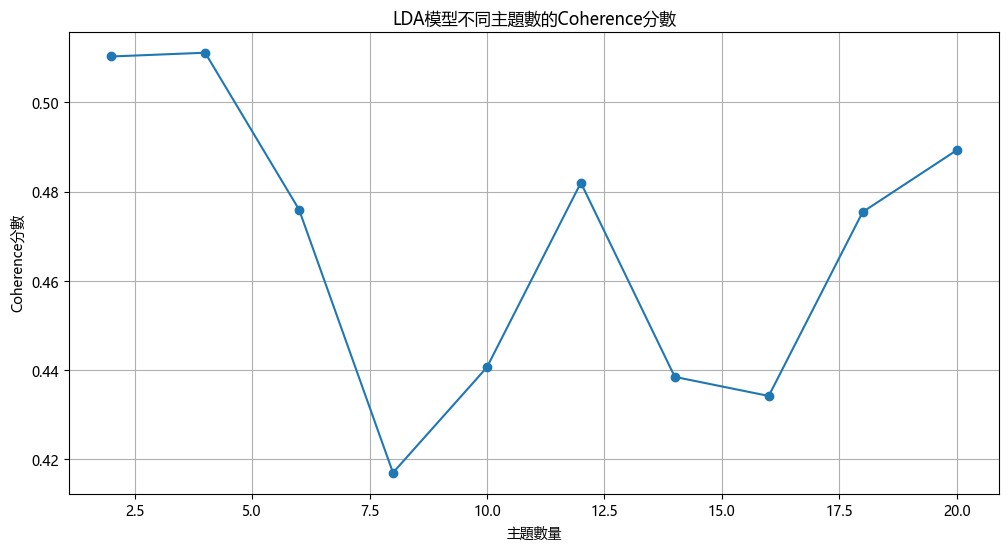

2025-06-09 16:15:17,064 : INFO : topic #0 (0.250): 0.014*"可愛" + 0.010*"日本" + 0.008*"美食" + 0.007*"兔兔" + 0.007*"小八貓" + 0.005*"角色" + 0.005*"活動" + 0.005*"聯名" + 0.005*"限定" + 0.005*"真的"
2025-06-09 16:15:17,065 : INFO : topic #1 (0.250): 0.057*"銅鑼灣" + 0.052*"日本" + 0.045*"代購" + 0.041*"公仔" + 0.037*"玩具" + 0.022*"對面" + 0.019*"精品" + 0.019*"香港" + 0.018*"旺角" + 0.017*"購物"
2025-06-09 16:15:17,066 : INFO : topic #2 (0.250): 0.046*"日本" + 0.040*"代購" + 0.022*"兔兔" + 0.015*"小八貓" + 0.015*"公仔" + 0.009*"下單" + 0.009*"網站" + 0.008*"現貨" + 0.008*"貨品" + 0.007*"小桃"
2025-06-09 16:15:17,067 : INFO : topic #3 (0.250): 0.030*"蛋糕" + 0.030*"迷因" + 0.027*"喜歡" + 0.027*"追蹤" + 0.024*"壽司" + 0.017*"扭蛋" + 0.015*"翻譯" + 0.008*"人生" + 0.008*"梗圖" + 0.008*"世界"


最佳主題數量: 4, Coherence分數: 0.5111
最佳LDA模型的主題:
主題 #0: 0.014*"可愛" + 0.010*"日本" + 0.008*"美食" + 0.007*"兔兔" + 0.007*"小八貓" + 0.005*"角色" + 0.005*"活動" + 0.005*"聯名" + 0.005*"限定" + 0.005*"真的"
主題 #1: 0.057*"銅鑼灣" + 0.052*"日本" + 0.045*"代購" + 0.041*"公仔" + 0.037*"玩具" + 0.022*"對面" + 0.019*"精品" + 0.019*"香港" + 0.018*"旺角" + 0.017*"購物"
主題 #2: 0.046*"日本" + 0.040*"代購" + 0.022*"兔兔" + 0.015*"小八貓" + 0.015*"公仔" + 0.009*"下單" + 0.009*"網站" + 0.008*"現貨" + 0.008*"貨品" + 0.007*"小桃"
主題 #3: 0.030*"蛋糕" + 0.030*"迷因" + 0.027*"喜歡" + 0.027*"追蹤" + 0.024*"壽司" + 0.017*"扭蛋" + 0.015*"翻譯" + 0.008*"人生" + 0.008*"梗圖" + 0.008*"世界"


In [11]:
# 設定主題數量範圍進行評估
topic_range = range(2, 21, 2)  # 從2到20，步長為2
coherence_scores = []
perplexity_scores = []
models = []

start = time.time()
for num_topics in topic_range:
    print(f"訓練 {num_topics} 個主題的LDA模型...")
    
    # 訓練LDA模型
    lda_model = LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        workers=4,  # 使用多核心加速
        passes=10,  # 迭代次數
        random_state=42
    )
    
    # 計算coherence分數
    coherence_model = CoherenceModel(
        model=lda_model, 
        texts=df['tokenized_text'], 
        dictionary=dictionary, 
        coherence='c_v'
    )
    coherence = coherence_model.get_coherence()
    coherence_scores.append(coherence)
    
    # 計算perplexity分數
    perplexity = lda_model.log_perplexity(corpus)
    perplexity_scores.append(perplexity)
    
    models.append(lda_model)
    
    print(f"主題數量: {num_topics}, Coherence: {coherence:.4f}, Perplexity: {perplexity:.4f}")

end = time.time()
print(f"LDA模型訓練和評估完成，耗時: {end - start:.2f}秒")

# 繪製coherence分數的變化圖
plt.figure(figsize=(12, 6))
plt.plot(topic_range, coherence_scores, 'o-')
plt.title('LDA模型不同主題數的Coherence分數')
plt.xlabel('主題數量')
plt.ylabel('Coherence分數')
plt.grid(True)
plt.show()

# 找出最佳主題數量
best_index = coherence_scores.index(max(coherence_scores))
best_num_topics = topic_range[best_index]
best_model = models[best_index]

print(f"最佳主題數量: {best_num_topics}, Coherence分數: {coherence_scores[best_index]:.4f}")

# 顯示最佳模型的主題
print("最佳LDA模型的主題:")
for topic_id, topic in best_model.print_topics(num_words=10):
    print(f"主題 #{topic_id}: {topic}")


5.延伸上述的LDA前處理，這邊進行實際的vis視覺化
除了生成vis視覺化外，還進行分析前五篇文章的主題分布，如第一篇文章綠色(也就是主題2)的部分佔多數，大致上可以判斷第一篇文章偏向主題2的討論
且列出四個主題的前十大字詞數量，從字詞判斷主題為這四種

    0: '商品代購',
    1: '角色討論',
    2: '線下活動',
    3: '迷因創作'

d:\anaconda\envs\tf1_env\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


LDA視覺化結果已保存到 'lda_visualization.html'
前5篇文章的主題分布:
    Topic 0   Topic 1   Topic 2   Topic 3
0  0.089082  0.084217  0.742708  0.083993
1       NaN       NaN  0.972818       NaN
2  0.980404  0.012276       NaN       NaN
3  0.702700       NaN       NaN  0.288701
4  0.699100       NaN       NaN  0.292447


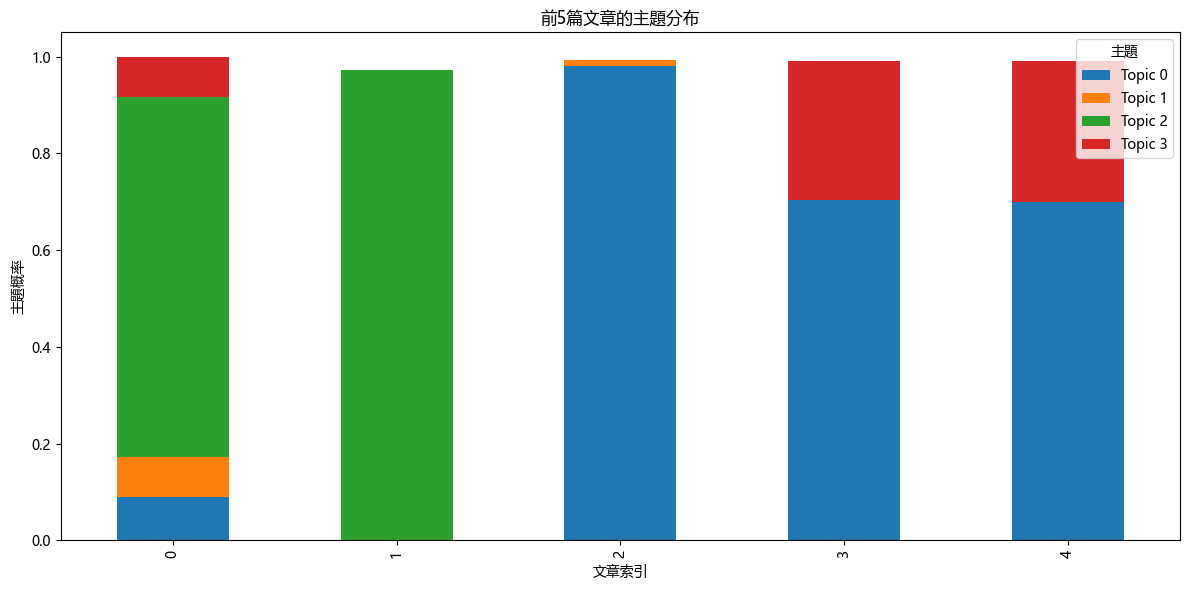

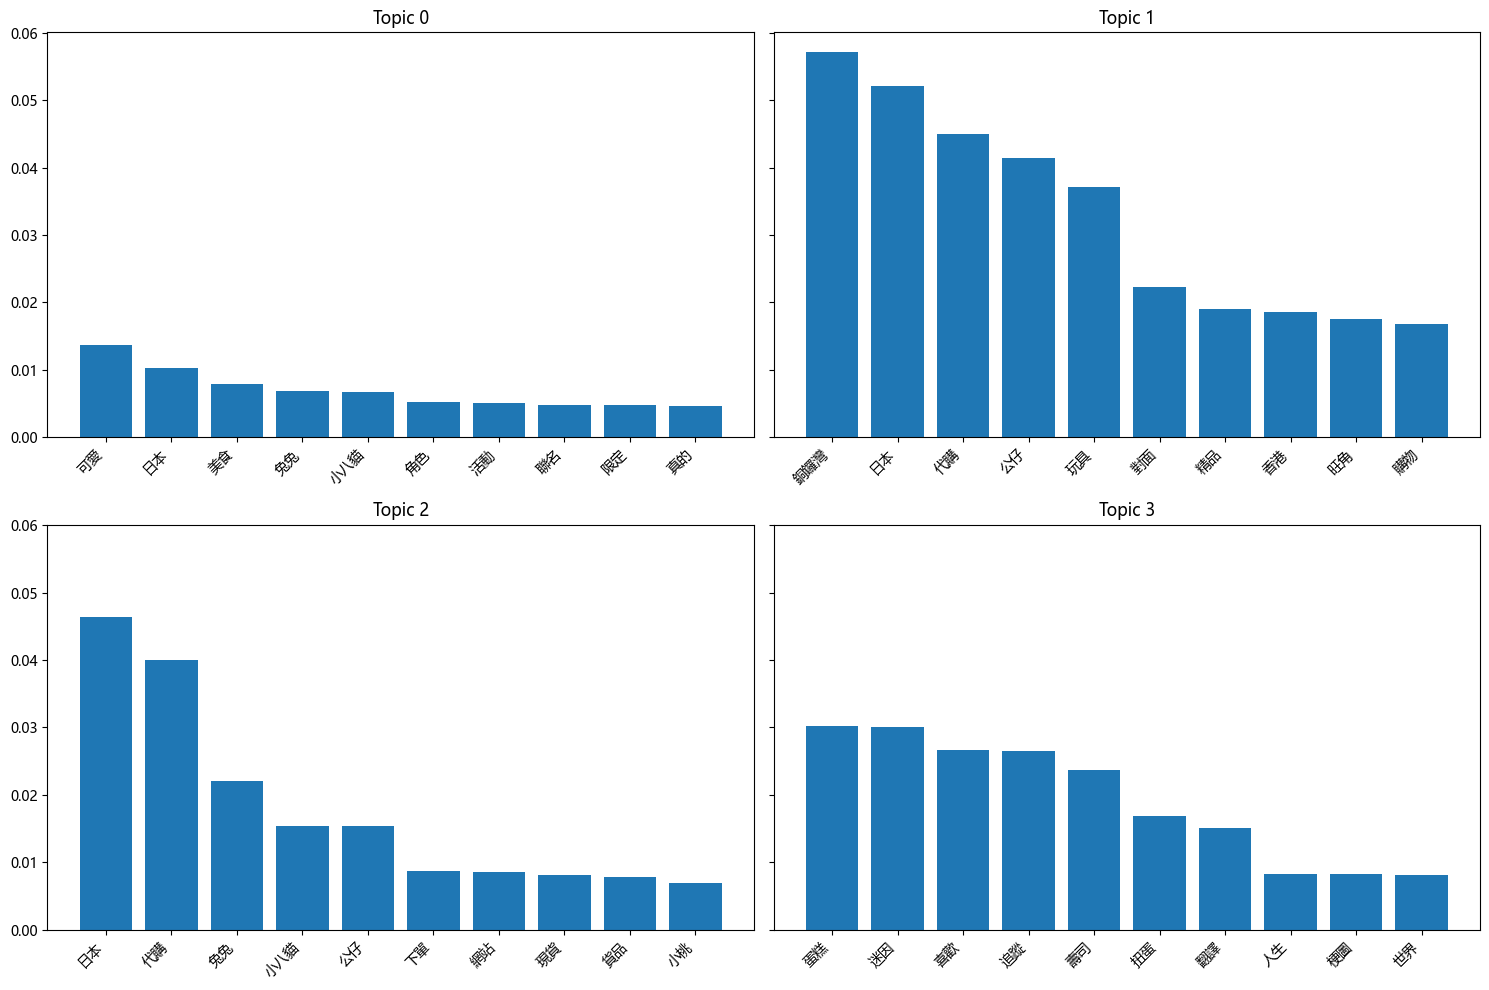

In [12]:
# 生成pyLDAvis視覺化
vis_data = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary, n_jobs=1)
pyLDAvis.display(vis_data)

# 保存視覺化結果到HTML文件
pyLDAvis.save_html(vis_data, 'lda_visualization.html')
print("LDA視覺化結果已保存到 'lda_visualization.html'")

# 視覺化每篇文章的主題分布
def get_document_topics(lda_model, corpus, n_docs=5):
    doc_topics = []
    for i, doc in enumerate(corpus[:n_docs]):  # 只取前n_docs篇文章
        topic_probs = lda_model.get_document_topics(doc)
        # 將主題概率轉為字典
        topic_dict = {f"Topic {topic_id}": prob for topic_id, prob in topic_probs}
        doc_topics.append(topic_dict)
    return pd.DataFrame(doc_topics)

# 獲取前5篇文章的主題分布
doc_topics_df = get_document_topics(best_model, corpus)
print("前5篇文章的主題分布:")
print(doc_topics_df)

# 視覺化前5篇文章的主題分布
doc_topics_df.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('前5篇文章的主題分布')
plt.xlabel('文章索引')
plt.ylabel('主題概率')
plt.legend(title='主題')
plt.tight_layout()
plt.show()

# 主題詞可視化
topics = best_model.show_topics(formatted=False, num_topics=best_num_topics, num_words=10)
fig, axes = plt.subplots(2, (best_num_topics+1)//2, figsize=(15, 10), sharey=True)
axes = axes.flatten()

for i, (topic_id, topic_words) in enumerate(topics):
    words = [word for word, _ in topic_words]
    weights = [weight for _, weight in topic_words]
    
    axes[i].bar(range(len(words)), weights, tick_label=words)
    axes[i].set_title(f'Topic {topic_id}')
    axes[i].set_xticklabels(words, rotation=45, ha='right')

plt.tight_layout()
plt.show()


6.由於前一段的LDA模型是跑所有平台的分析，可能各個平台會有不同的可能性，故我們分別在處理了'IG', 'YT', 'PTT'三平台的LDA內容，結果如下

IG：可愛形象、迷因、美食、代購、精品分享
YT：頻道經營、商品開箱、角色介紹、國際話題
PTT：活動/新聞、商品交易、角色討論


處理 IG 平台資料 - 主題數量評估
IG 平台原始資料筆數: 11134


2025-06-09 22:14:39,361 : INFO : adding document #0 to Dictionary<0 unique tokens: []>


IG 平台有效資料筆數: 11134


2025-06-09 22:14:39,968 : INFO : adding document #10000 to Dictionary<30983 unique tokens: ['卡龍', '吉伊卡哇', '奶香', '寶寶', '小八貓']...>
2025-06-09 22:14:40,036 : INFO : built Dictionary<31135 unique tokens: ['卡龍', '吉伊卡哇', '奶香', '寶寶', '小八貓']...> from 11134 documents (total 555967 corpus positions)
2025-06-09 22:14:40,037 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<31135 unique tokens: ['卡龍', '吉伊卡哇', '奶香', '寶寶', '小八貓']...> from 11134 documents (total 555967 corpus positions)", 'datetime': '2025-06-09T22:14:40.037504', 'gensim': '4.2.0', 'python': '3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:35:01) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'created'}
2025-06-09 22:14:40,072 : INFO : discarding 12456 tokens: [('吉伊卡哇', 9783), ('一封', 1), ('信紙信封', 1), ('度破表', 1), ('正興', 1), ('原画', 1), ('夢展', 1), ('狗愛吃', 1), ('小學生', 1), ('屏息', 1)]...
2025-06-09 22:14:40,073 : INFO : keeping 18679 tokens which were in no less than 2 and no more t

IG 平台原始字典大小: 31135
IG 平台過濾後字典大小: 18679


2025-06-09 22:14:40,415 : INFO : using symmetric alpha at 0.5
2025-06-09 22:14:40,416 : INFO : using symmetric eta at 0.5
2025-06-09 22:14:40,434 : INFO : using serial LDA version on this node
2025-06-09 22:14:40,457 : INFO : running online LDA training, 2 topics, 10 passes over the supplied corpus of 11134 documents, updating every 4000 documents, evaluating every ~11134 documents, iterating 50x with a convergence threshold of 0.001000
2025-06-09 22:14:40,466 : INFO : training LDA model using 2 processes



開始 IG 平台的主題數量評估，範圍: 2 到 15
訓練 IG 平台 2 個主題的LDA模型...


2025-06-09 22:14:43,009 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/11134, outstanding queue size 1
2025-06-09 22:14:43,023 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/11134, outstanding queue size 2
2025-06-09 22:14:43,040 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/11134, outstanding queue size 3
2025-06-09 22:14:43,062 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/11134, outstanding queue size 4
2025-06-09 22:14:43,063 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/11134, outstanding queue size 5
2025-06-09 22:14:43,064 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #11134/11134, outstanding queue size 6
2025-06-09 22:14:44,511 : INFO : merging changes from 4000 documents into a model of 11134 documents
2025-06-09 22:14:44,562 : INFO : topic #0 (0.500): 0.017*"日本" + 0.014*"公仔" + 0.011*"兔兔" + 0.010*"蛋糕" + 0.010*"代購" + 0.009*"小八貓" + 0.009

主題數量: 2, Coherence: 0.5444, Perplexity: -7.4562
訓練 IG 平台 3 個主題的LDA模型...


2025-06-09 22:15:21,738 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/11134, outstanding queue size 1
2025-06-09 22:15:21,750 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/11134, outstanding queue size 2
2025-06-09 22:15:21,751 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/11134, outstanding queue size 3
2025-06-09 22:15:21,797 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/11134, outstanding queue size 4
2025-06-09 22:15:21,798 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/11134, outstanding queue size 5
2025-06-09 22:15:21,799 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #11134/11134, outstanding queue size 6
2025-06-09 22:15:23,149 : INFO : merging changes from 4000 documents into a model of 11134 documents
2025-06-09 22:15:23,153 : INFO : topic #0 (0.333): 0.015*"日本" + 0.015*"蛋糕" + 0.014*"公仔" + 0.009*"小八貓" + 0.008*"兔兔" + 0.008*"代購" + 0.008

主題數量: 3, Coherence: 0.6663, Perplexity: -7.3953
訓練 IG 平台 4 個主題的LDA模型...


2025-06-09 22:16:05,668 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/11134, outstanding queue size 1
2025-06-09 22:16:05,681 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/11134, outstanding queue size 2
2025-06-09 22:16:05,696 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/11134, outstanding queue size 3
2025-06-09 22:16:05,717 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/11134, outstanding queue size 4
2025-06-09 22:16:05,719 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/11134, outstanding queue size 5
2025-06-09 22:16:05,720 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #11134/11134, outstanding queue size 6
2025-06-09 22:16:07,180 : INFO : merging changes from 4000 documents into a model of 11134 documents
2025-06-09 22:16:07,184 : INFO : topic #0 (0.250): 0.016*"日本" + 0.014*"蛋糕" + 0.012*"公仔" + 0.008*"小八貓" + 0.008*"代購" + 0.008*"可愛" + 0.007

主題數量: 4, Coherence: 0.5843, Perplexity: -7.2997
訓練 IG 平台 5 個主題的LDA模型...


2025-06-09 22:16:48,800 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/11134, outstanding queue size 1
2025-06-09 22:16:48,812 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/11134, outstanding queue size 2
2025-06-09 22:16:48,825 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/11134, outstanding queue size 3
2025-06-09 22:16:48,846 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/11134, outstanding queue size 4
2025-06-09 22:16:48,847 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/11134, outstanding queue size 5
2025-06-09 22:16:48,849 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #11134/11134, outstanding queue size 6
2025-06-09 22:16:50,066 : INFO : merging changes from 4000 documents into a model of 11134 documents
2025-06-09 22:16:50,071 : INFO : topic #0 (0.200): 0.019*"蛋糕" + 0.015*"日本" + 0.013*"公仔" + 0.009*"代購" + 0.008*"小八貓" + 0.008*"系列" + 0.007

主題數量: 5, Coherence: 0.5516, Perplexity: -7.2277
訓練 IG 平台 6 個主題的LDA模型...


2025-06-09 22:17:31,141 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/11134, outstanding queue size 1
2025-06-09 22:17:31,153 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/11134, outstanding queue size 2
2025-06-09 22:17:31,166 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/11134, outstanding queue size 3
2025-06-09 22:17:31,198 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/11134, outstanding queue size 4
2025-06-09 22:17:31,201 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/11134, outstanding queue size 5
2025-06-09 22:17:31,202 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #11134/11134, outstanding queue size 6
2025-06-09 22:17:32,489 : INFO : merging changes from 4000 documents into a model of 11134 documents
2025-06-09 22:17:32,497 : INFO : topic #5 (0.167): 0.022*"日本" + 0.010*"可愛" + 0.008*"兔兔" + 0.007*"小八貓" + 0.006*"限定" + 0.005*"留言" + 0.005

主題數量: 6, Coherence: 0.5274, Perplexity: -7.2145
訓練 IG 平台 7 個主題的LDA模型...


2025-06-09 22:18:13,255 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/11134, outstanding queue size 1
2025-06-09 22:18:13,270 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/11134, outstanding queue size 2
2025-06-09 22:18:13,286 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/11134, outstanding queue size 3
2025-06-09 22:18:13,308 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/11134, outstanding queue size 4
2025-06-09 22:18:13,309 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/11134, outstanding queue size 5
2025-06-09 22:18:13,310 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #11134/11134, outstanding queue size 6
2025-06-09 22:18:14,660 : INFO : merging changes from 4000 documents into a model of 11134 documents
2025-06-09 22:18:14,670 : INFO : topic #2 (0.143): 0.043*"銅鑼灣" + 0.031*"日本" + 0.030*"玩具" + 0.023*"兔兔" + 0.022*"代購" + 0.018*"公仔" + 0.015

主題數量: 7, Coherence: 0.5087, Perplexity: -7.1650
訓練 IG 平台 8 個主題的LDA模型...


2025-06-09 22:18:56,879 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/11134, outstanding queue size 1
2025-06-09 22:18:56,895 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/11134, outstanding queue size 2
2025-06-09 22:18:56,913 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/11134, outstanding queue size 3
2025-06-09 22:18:56,942 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/11134, outstanding queue size 4
2025-06-09 22:18:56,944 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/11134, outstanding queue size 5
2025-06-09 22:18:56,947 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #11134/11134, outstanding queue size 6
2025-06-09 22:18:58,573 : INFO : merging changes from 4000 documents into a model of 11134 documents
2025-06-09 22:18:58,582 : INFO : topic #5 (0.125): 0.021*"日本" + 0.010*"可愛" + 0.008*"兔兔" + 0.008*"小八貓" + 0.005*"留言" + 0.005*"代購" + 0.004

主題數量: 8, Coherence: 0.5218, Perplexity: -7.0956
訓練 IG 平台 9 個主題的LDA模型...


2025-06-09 22:19:40,494 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/11134, outstanding queue size 1
2025-06-09 22:19:40,512 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/11134, outstanding queue size 2
2025-06-09 22:19:40,541 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/11134, outstanding queue size 3
2025-06-09 22:19:40,599 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/11134, outstanding queue size 4
2025-06-09 22:19:40,600 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/11134, outstanding queue size 5
2025-06-09 22:19:40,602 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #11134/11134, outstanding queue size 6
2025-06-09 22:19:42,005 : INFO : merging changes from 4000 documents into a model of 11134 documents
2025-06-09 22:19:42,014 : INFO : topic #0 (0.111): 0.026*"蛋糕" + 0.013*"日本" + 0.012*"公仔" + 0.009*"代購" + 0.008*"系列" + 0.008*"小八貓" + 0.007

主題數量: 9, Coherence: 0.5445, Perplexity: -7.0635
訓練 IG 平台 10 個主題的LDA模型...


2025-06-09 22:20:25,110 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/11134, outstanding queue size 1
2025-06-09 22:20:25,124 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/11134, outstanding queue size 2
2025-06-09 22:20:25,144 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/11134, outstanding queue size 3
2025-06-09 22:20:25,173 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/11134, outstanding queue size 4
2025-06-09 22:20:25,174 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/11134, outstanding queue size 5
2025-06-09 22:20:25,174 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #11134/11134, outstanding queue size 6
2025-06-09 22:20:26,479 : INFO : merging changes from 4000 documents into a model of 11134 documents
2025-06-09 22:20:26,489 : INFO : topic #5 (0.100): 0.023*"日本" + 0.010*"可愛" + 0.008*"兔兔" + 0.008*"小八貓" + 0.005*"代購" + 0.005*"留言" + 0.004

主題數量: 10, Coherence: 0.5407, Perplexity: -7.0379
訓練 IG 平台 11 個主題的LDA模型...


2025-06-09 22:21:18,957 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/11134, outstanding queue size 1
2025-06-09 22:21:18,972 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/11134, outstanding queue size 2
2025-06-09 22:21:18,991 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/11134, outstanding queue size 3
2025-06-09 22:21:18,993 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/11134, outstanding queue size 4
2025-06-09 22:21:19,022 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/11134, outstanding queue size 5
2025-06-09 22:21:19,024 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #11134/11134, outstanding queue size 6
2025-06-09 22:21:20,433 : INFO : merging changes from 4000 documents into a model of 11134 documents
2025-06-09 22:21:20,445 : INFO : topic #0 (0.091): 0.028*"蛋糕" + 0.011*"日本" + 0.009*"公仔" + 0.009*"高雄" + 0.008*"代購" + 0.008*"系列" + 0.008*

主題數量: 11, Coherence: 0.5110, Perplexity: -7.0424
訓練 IG 平台 12 個主題的LDA模型...


2025-06-09 22:22:02,043 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/11134, outstanding queue size 1
2025-06-09 22:22:02,062 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/11134, outstanding queue size 2
2025-06-09 22:22:02,081 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/11134, outstanding queue size 3
2025-06-09 22:22:02,118 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/11134, outstanding queue size 4
2025-06-09 22:22:02,120 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/11134, outstanding queue size 5
2025-06-09 22:22:02,121 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #11134/11134, outstanding queue size 6
2025-06-09 22:22:03,502 : INFO : merging changes from 4000 documents into a model of 11134 documents
2025-06-09 22:22:03,514 : INFO : topic #10 (0.083): 0.059*"銅鑼灣" + 0.047*"日本" + 0.030*"玩具" + 0.026*"公仔" + 0.021*"代購" + 0.019*"購物" + 0.01

主題數量: 12, Coherence: 0.5326, Perplexity: -7.0267
訓練 IG 平台 13 個主題的LDA模型...


2025-06-09 22:22:48,131 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/11134, outstanding queue size 1
2025-06-09 22:22:48,147 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/11134, outstanding queue size 2
2025-06-09 22:22:48,164 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/11134, outstanding queue size 3
2025-06-09 22:22:48,193 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/11134, outstanding queue size 4
2025-06-09 22:22:48,194 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/11134, outstanding queue size 5
2025-06-09 22:22:48,196 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #11134/11134, outstanding queue size 6
2025-06-09 22:22:49,501 : INFO : merging changes from 4000 documents into a model of 11134 documents
2025-06-09 22:22:49,515 : INFO : topic #4 (0.077): 0.018*"喜歡" + 0.017*"追蹤" + 0.016*"迷因" + 0.012*"兔兔" + 0.010*"可愛" + 0.009*"日本" + 0.009*

主題數量: 13, Coherence: 0.5158, Perplexity: -7.0063
訓練 IG 平台 14 個主題的LDA模型...


2025-06-09 22:23:31,806 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/11134, outstanding queue size 1
2025-06-09 22:23:31,818 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/11134, outstanding queue size 2
2025-06-09 22:23:31,821 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/11134, outstanding queue size 3
2025-06-09 22:23:31,836 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/11134, outstanding queue size 4
2025-06-09 22:23:31,856 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/11134, outstanding queue size 5
2025-06-09 22:23:31,858 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #11134/11134, outstanding queue size 6
2025-06-09 22:23:33,242 : INFO : merging changes from 4000 documents into a model of 11134 documents
2025-06-09 22:23:33,257 : INFO : topic #6 (0.071): 0.031*"日本" + 0.011*"兔兔" + 0.010*"代購" + 0.009*"喜歡" + 0.009*"可愛" + 0.008*"小八貓" + 0.008

主題數量: 14, Coherence: 0.5028, Perplexity: -6.9814
訓練 IG 平台 15 個主題的LDA模型...


2025-06-09 22:24:16,903 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/11134, outstanding queue size 1
2025-06-09 22:24:16,920 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/11134, outstanding queue size 2
2025-06-09 22:24:16,922 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/11134, outstanding queue size 3
2025-06-09 22:24:16,938 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/11134, outstanding queue size 4
2025-06-09 22:24:16,964 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/11134, outstanding queue size 5
2025-06-09 22:24:16,966 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #11134/11134, outstanding queue size 6
2025-06-09 22:24:18,410 : INFO : merging changes from 4000 documents into a model of 11134 documents
2025-06-09 22:24:18,426 : INFO : topic #10 (0.067): 0.064*"銅鑼灣" + 0.049*"日本" + 0.033*"玩具" + 0.028*"公仔" + 0.021*"代購" + 0.020*"購物" + 0.01

主題數量: 15, Coherence: 0.4902, Perplexity: -6.9640
IG 平台LDA模型訓練和評估完成，耗時: 625.45秒


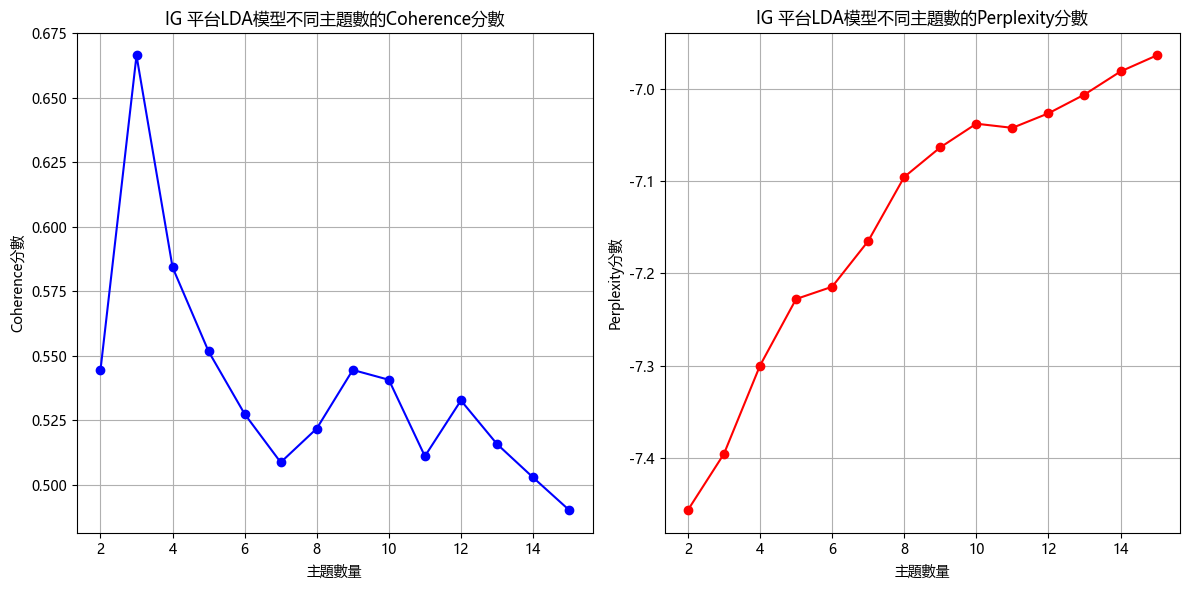

2025-06-09 22:25:08,750 : INFO : topic #0 (0.333): 0.012*"可愛" + 0.011*"喜歡" + 0.010*"蛋糕" + 0.009*"追蹤" + 0.008*"迷因" + 0.007*"小八貓" + 0.007*"美食" + 0.006*"壽司" + 0.006*"兔兔" + 0.006*"活動"
2025-06-09 22:25:08,826 : INFO : topic #1 (0.333): 0.044*"日本" + 0.037*"代購" + 0.016*"旺角" + 0.014*"門市" + 0.013*"八字" + 0.012*"下單" + 0.011*"兔兔" + 0.009*"現貨" + 0.009*"付款" + 0.009*"東京"
2025-06-09 22:25:08,828 : INFO : topic #2 (0.333): 0.052*"銅鑼灣" + 0.047*"日本" + 0.044*"公仔" + 0.035*"玩具" + 0.033*"代購" + 0.021*"兔兔" + 0.020*"香港" + 0.020*"精品" + 0.017*"購物" + 0.016*"對面"



IG 平台最佳主題數量: 3, Coherence分數: 0.6663

IG 平台最佳LDA模型的主題:
主題 #0: 0.012*"可愛" + 0.011*"喜歡" + 0.010*"蛋糕" + 0.009*"追蹤" + 0.008*"迷因" + 0.007*"小八貓" + 0.007*"美食" + 0.006*"壽司" + 0.006*"兔兔" + 0.006*"活動"
主題 #1: 0.044*"日本" + 0.037*"代購" + 0.016*"旺角" + 0.014*"門市" + 0.013*"八字" + 0.012*"下單" + 0.011*"兔兔" + 0.009*"現貨" + 0.009*"付款" + 0.009*"東京"
主題 #2: 0.052*"銅鑼灣" + 0.047*"日本" + 0.044*"公仔" + 0.035*"玩具" + 0.033*"代購" + 0.021*"兔兔" + 0.020*"香港" + 0.020*"精品" + 0.017*"購物" + 0.016*"對面"

處理 YT 平台資料 - 主題數量評估
YT 平台原始資料筆數: 462


2025-06-09 22:25:10,631 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2025-06-09 22:25:10,686 : INFO : built Dictionary<7213 unique tokens: ['吉伊卡哇', '小八貓', '跳舞', '一千萬', '中文歌詞']...> from 462 documents (total 22006 corpus positions)
2025-06-09 22:25:10,687 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<7213 unique tokens: ['吉伊卡哇', '小八貓', '跳舞', '一千萬', '中文歌詞']...> from 462 documents (total 22006 corpus positions)", 'datetime': '2025-06-09T22:25:10.687179', 'gensim': '4.2.0', 'python': '3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:35:01) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'created'}
2025-06-09 22:25:10,702 : INFO : discarding 4689 tokens: [('吉伊卡哇', 444), ('剛到', 1), ('熱騰騰', 1), ('盲包', 1), ('迫不及待', 1), ('........', 1), ('回煉', 1), ('沒錢', 1), ('金坊', 1), ('貪心', 1)]...
2025-06-09 22:25:10,703 : INFO : keeping 2524 tokens which were in no less than 2 and no more than 369 (=80.0%) documents
2025-06-09 22:25

YT 平台有效資料筆數: 462
YT 平台原始字典大小: 7213
YT 平台過濾後字典大小: 2524

開始 YT 平台的主題數量評估，範圍: 2 到 15
訓練 YT 平台 2 個主題的LDA模型...


2025-06-09 22:25:15,884 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #462/462, outstanding queue size 1
2025-06-09 22:25:16,244 : INFO : topic #0 (0.500): 0.011*"新聞" + 0.009*"訂閱" + 0.008*"娃娃" + 0.008*"頻道" + 0.007*"影片" + 0.007*"直播" + 0.006*"可愛" + 0.005*"日本" + 0.005*"會員" + 0.005*"開箱"
2025-06-09 22:25:16,244 : INFO : topic #1 (0.500): 0.013*"扭蛋" + 0.012*"壽司" + 0.010*"日本" + 0.008*"影片" + 0.007*"新聞" + 0.005*"直播" + 0.005*"可愛" + 0.005*"訂閱" + 0.005*"東京" + 0.005*"頻道"
2025-06-09 22:25:16,246 : INFO : topic diff=0.721670, rho=1.000000
2025-06-09 22:25:16,522 : INFO : -7.537 per-word bound, 185.8 perplexity estimate based on a held-out corpus of 462 documents with 15442 words
2025-06-09 22:25:16,524 : INFO : PROGRESS: pass 1, dispatched chunk #0 = documents up to #462/462, outstanding queue size 1
2025-06-09 22:25:16,776 : INFO : topic #0 (0.500): 0.012*"新聞" + 0.009*"訂閱" + 0.009*"娃娃" + 0.008*"頻道" + 0.008*"直播" + 0.007*"可愛" + 0.006*"影片" + 0.006*"會員" + 0.006*"台灣" + 0.005*"開箱"
2025-

主題數量: 2, Coherence: 0.4555, Perplexity: -7.3653
訓練 YT 平台 3 個主題的LDA模型...


2025-06-09 22:25:36,111 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #462/462, outstanding queue size 1
2025-06-09 22:25:36,467 : INFO : topic #0 (0.333): 0.010*"新聞" + 0.008*"頻道" + 0.008*"訂閱" + 0.007*"娃娃" + 0.006*"直播" + 0.006*"玩具" + 0.006*"一番賞" + 0.006*"嗚話" + 0.005*"可愛" + 0.005*"影片"
2025-06-09 22:25:36,468 : INFO : topic #1 (0.333): 0.017*"扭蛋" + 0.014*"壽司" + 0.010*"日本" + 0.008*"東京" + 0.008*"影片" + 0.006*"聯名" + 0.005*"嗚話" + 0.005*"頻道" + 0.004*"新聞" + 0.004*"直播"
2025-06-09 22:25:36,469 : INFO : topic #2 (0.333): 0.012*"新聞" + 0.009*"影片" + 0.009*"日本" + 0.008*"訂閱" + 0.008*"娃娃" + 0.008*"可愛" + 0.007*"壽司" + 0.007*"直播" + 0.006*"頻道" + 0.006*"扭蛋"
2025-06-09 22:25:36,469 : INFO : topic diff=0.967347, rho=1.000000
2025-06-09 22:25:36,682 : INFO : -7.597 per-word bound, 193.7 perplexity estimate based on a held-out corpus of 462 documents with 15442 words
2025-06-09 22:25:36,683 : INFO : PROGRESS: pass 1, dispatched chunk #0 = documents up to #462/462, outstanding queue size 1
2025

主題數量: 3, Coherence: 0.4204, Perplexity: -7.2971
訓練 YT 平台 4 個主題的LDA模型...


2025-06-09 22:25:54,526 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #462/462, outstanding queue size 1
2025-06-09 22:25:54,786 : INFO : topic #0 (0.250): 0.011*"新聞" + 0.009*"頻道" + 0.009*"訂閱" + 0.008*"一番賞" + 0.008*"直播" + 0.007*"玩具" + 0.007*"嗚話" + 0.005*"可愛" + 0.005*"娃娃" + 0.005*"開箱"
2025-06-09 22:25:54,787 : INFO : topic #1 (0.250): 0.018*"扭蛋" + 0.017*"壽司" + 0.012*"日本" + 0.010*"東京" + 0.008*"影片" + 0.008*"嗚話" + 0.007*"聯名" + 0.005*"角色" + 0.005*"新聞" + 0.004*"直播"
2025-06-09 22:25:54,788 : INFO : topic #2 (0.250): 0.013*"新聞" + 0.010*"影片" + 0.010*"日本" + 0.009*"訂閱" + 0.008*"可愛" + 0.008*"壽司" + 0.007*"娃娃" + 0.007*"直播" + 0.007*"扭蛋" + 0.006*"頻道"
2025-06-09 22:25:54,789 : INFO : topic #3 (0.250): 0.010*"娃娃" + 0.007*"影片" + 0.007*"波子" + 0.006*"扭蛋" + 0.006*"新聞" + 0.006*"劉萱" + 0.006*"頻道" + 0.006*"訂閱" + 0.005*"合作" + 0.005*"可愛"
2025-06-09 22:25:54,789 : INFO : topic diff=1.350156, rho=1.000000
2025-06-09 22:25:54,976 : INFO : -7.648 per-word bound, 200.6 perplexity estimate based on a

主題數量: 4, Coherence: 0.4319, Perplexity: -7.2786
訓練 YT 平台 5 個主題的LDA模型...


2025-06-09 22:26:13,101 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #462/462, outstanding queue size 1
2025-06-09 22:26:13,395 : INFO : topic #0 (0.200): 0.011*"新聞" + 0.009*"一番賞" + 0.009*"頻道" + 0.009*"訂閱" + 0.009*"玩具" + 0.008*"直播" + 0.006*"可愛" + 0.006*"嗚話" + 0.005*"開箱" + 0.005*"台北"
2025-06-09 22:26:13,396 : INFO : topic #1 (0.200): 0.020*"扭蛋" + 0.017*"壽司" + 0.013*"日本" + 0.009*"東京" + 0.009*"影片" + 0.008*"聯名" + 0.006*"嗚話" + 0.005*"角色" + 0.005*"可愛" + 0.005*"介紹"
2025-06-09 22:26:13,398 : INFO : topic #2 (0.200): 0.013*"新聞" + 0.011*"日本" + 0.010*"壽司" + 0.010*"影片" + 0.009*"可愛" + 0.009*"訂閱" + 0.007*"直播" + 0.007*"扭蛋" + 0.007*"娃娃" + 0.006*"開箱"
2025-06-09 22:26:13,398 : INFO : topic #3 (0.200): 0.007*"娃娃" + 0.007*"劉萱" + 0.007*"影片" + 0.007*"波子" + 0.007*"扭蛋" + 0.006*"合作" + 0.006*"開箱" + 0.006*"可愛" + 0.006*"精華" + 0.005*"頻道"
2025-06-09 22:26:13,399 : INFO : topic #4 (0.200): 0.011*"新聞" + 0.011*"娃娃" + 0.010*"頻道" + 0.009*"訂閱" + 0.007*"影片" + 0.007*"嗚話" + 0.006*"壽司" + 0.006*"扭蛋" + 0.00

主題數量: 5, Coherence: 0.4625, Perplexity: -7.2483
訓練 YT 平台 6 個主題的LDA模型...


2025-06-09 22:26:31,903 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #462/462, outstanding queue size 1
2025-06-09 22:26:32,259 : INFO : topic #4 (0.167): 0.013*"新聞" + 0.010*"頻道" + 0.009*"娃娃" + 0.008*"壽司" + 0.008*"訂閱" + 0.007*"直播" + 0.007*"東京" + 0.007*"扭蛋" + 0.006*"兔兔" + 0.005*"影片"
2025-06-09 22:26:32,261 : INFO : topic #0 (0.167): 0.012*"新聞" + 0.010*"頻道" + 0.009*"訂閱" + 0.008*"直播" + 0.008*"一番賞" + 0.007*"可愛" + 0.005*"玩具" + 0.005*"粉絲" + 0.005*"日本" + 0.005*"台灣"
2025-06-09 22:26:32,262 : INFO : topic #1 (0.167): 0.022*"扭蛋" + 0.020*"壽司" + 0.016*"日本" + 0.011*"東京" + 0.009*"影片" + 0.008*"聯名" + 0.005*"直播" + 0.004*"角色" + 0.004*"粉絲" + 0.004*"可愛"
2025-06-09 22:26:32,263 : INFO : topic #3 (0.167): 0.009*"娃娃" + 0.009*"劉萱" + 0.007*"著作" + 0.007*"精華" + 0.006*"動畫" + 0.006*"影片" + 0.006*"可愛" + 0.006*"合作" + 0.005*"漫畫" + 0.005*"新聞"
2025-06-09 22:26:32,264 : INFO : topic #5 (0.167): 0.014*"波子" + 0.014*"影片" + 0.009*"嗚話" + 0.009*"訂閱" + 0.008*"開箱" + 0.008*"玩具" + 0.007*"扭蛋" + 0.006*"頻道" + 0.00

主題數量: 6, Coherence: 0.4311, Perplexity: -7.2147
訓練 YT 平台 7 個主題的LDA模型...


2025-06-09 22:26:51,269 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #462/462, outstanding queue size 1
2025-06-09 22:26:51,555 : INFO : topic #5 (0.143): 0.016*"嗚話" + 0.015*"波子" + 0.014*"影片" + 0.009*"訂閱" + 0.009*"開箱" + 0.009*"玩具" + 0.007*"頻道" + 0.006*"貼圖" + 0.006*"娃娃" + 0.006*"公仔"
2025-06-09 22:26:51,556 : INFO : topic #0 (0.143): 0.013*"新聞" + 0.010*"頻道" + 0.010*"一番賞" + 0.009*"訂閱" + 0.009*"直播" + 0.006*"可愛" + 0.006*"玩具" + 0.005*"粉絲" + 0.005*"會員" + 0.005*"靜兒"
2025-06-09 22:26:51,557 : INFO : topic #1 (0.143): 0.024*"扭蛋" + 0.022*"壽司" + 0.015*"日本" + 0.010*"影片" + 0.007*"聯名" + 0.005*"東京" + 0.005*"直播" + 0.005*"粉絲" + 0.005*"角色" + 0.005*"中文"
2025-06-09 22:26:51,559 : INFO : topic #6 (0.143): 0.016*"日本" + 0.014*"壽司" + 0.011*"東京" + 0.011*"新聞" + 0.009*"可愛" + 0.007*"台灣" + 0.007*"聯名" + 0.007*"影片" + 0.006*"扭蛋" + 0.006*"閃店"
2025-06-09 22:26:51,561 : INFO : topic #4 (0.143): 0.011*"娃娃" + 0.011*"新聞" + 0.011*"頻道" + 0.008*"訂閱" + 0.007*"直播" + 0.007*"扭蛋" + 0.007*"壽司" + 0.005*"影片" + 0.00

主題數量: 7, Coherence: 0.4242, Perplexity: -7.1946
訓練 YT 平台 8 個主題的LDA模型...


2025-06-09 22:27:09,770 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #462/462, outstanding queue size 1
2025-06-09 22:27:10,057 : INFO : topic #7 (0.125): 0.014*"扭蛋" + 0.011*"直播" + 0.010*"尊重" + 0.008*"斋戒" + 0.008*"探店" + 0.008*"聊天室" + 0.007*"穆斯林" + 0.007*"学生" + 0.007*"頻道" + 0.007*"會員"
2025-06-09 22:27:10,058 : INFO : topic #4 (0.125): 0.012*"頻道" + 0.011*"新聞" + 0.010*"訂閱" + 0.009*"娃娃" + 0.008*"日本" + 0.006*"壽司" + 0.006*"扭蛋" + 0.006*"影片" + 0.006*"嗚話" + 0.006*"兔兔"
2025-06-09 22:27:10,058 : INFO : topic #1 (0.125): 0.024*"扭蛋" + 0.021*"壽司" + 0.015*"日本" + 0.009*"影片" + 0.009*"東京" + 0.007*"聯名" + 0.006*"角色" + 0.006*"介紹" + 0.006*"粉絲" + 0.005*"訂閱"
2025-06-09 22:27:10,060 : INFO : topic #5 (0.125): 0.017*"影片" + 0.017*"嗚話" + 0.016*"波子" + 0.011*"玩具" + 0.011*"開箱" + 0.011*"訂閱" + 0.007*"貼圖" + 0.007*"公仔" + 0.007*"頻道" + 0.007*"娃娃"
2025-06-09 22:27:10,062 : INFO : topic #0 (0.125): 0.015*"新聞" + 0.010*"頻道" + 0.010*"一番賞" + 0.010*"訂閱" + 0.007*"直播" + 0.006*"可愛" + 0.006*"粉絲" + 0.005*"靜兒" + 0.

主題數量: 8, Coherence: 0.4720, Perplexity: -7.1311
訓練 YT 平台 9 個主題的LDA模型...


2025-06-09 22:27:28,647 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #462/462, outstanding queue size 1
2025-06-09 22:27:28,931 : INFO : topic #2 (0.111): 0.016*"新聞" + 0.012*"日本" + 0.010*"影片" + 0.010*"訂閱" + 0.008*"可愛" + 0.008*"扭蛋" + 0.008*"娃娃" + 0.008*"壽司" + 0.007*"遊戲" + 0.007*"直播"
2025-06-09 22:27:28,932 : INFO : topic #8 (0.111): 0.014*"開箱" + 0.012*"娃娃" + 0.011*"壽司" + 0.011*"扭蛋" + 0.009*"頻道" + 0.008*"日本" + 0.007*"全家" + 0.007*"華山" + 0.006*"可愛" + 0.006*"直播"
2025-06-09 22:27:28,933 : INFO : topic #1 (0.111): 0.023*"扭蛋" + 0.018*"壽司" + 0.014*"日本" + 0.011*"影片" + 0.008*"聯名" + 0.008*"角色" + 0.006*"東京" + 0.006*"粉絲" + 0.006*"活動" + 0.005*"可愛"
2025-06-09 22:27:28,933 : INFO : topic #0 (0.111): 0.013*"新聞" + 0.011*"訂閱" + 0.010*"頻道" + 0.009*"一番賞" + 0.009*"直播" + 0.008*"可愛" + 0.007*"玩具" + 0.006*"食尚" + 0.006*"玩家" + 0.005*"台北"
2025-06-09 22:27:28,934 : INFO : topic #4 (0.111): 0.016*"新聞" + 0.012*"訂閱" + 0.011*"娃娃" + 0.010*"頻道" + 0.008*"東京" + 0.007*"嗚話" + 0.007*"直播" + 0.006*"扭蛋" + 0.00

主題數量: 9, Coherence: 0.4152, Perplexity: -7.1246
訓練 YT 平台 10 個主題的LDA模型...


2025-06-09 22:27:46,043 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #462/462, outstanding queue size 1
2025-06-09 22:27:46,340 : INFO : topic #8 (0.100): 0.016*"娃娃" + 0.013*"開箱" + 0.011*"頻道" + 0.010*"扭蛋" + 0.008*"壽司" + 0.008*"華山" + 0.007*"影片" + 0.007*"全家" + 0.007*"日本" + 0.006*"可愛"
2025-06-09 22:27:46,340 : INFO : topic #9 (0.100): 0.018*"新聞" + 0.016*"壽司" + 0.015*"扭蛋" + 0.012*"劉萱" + 0.009*"精華" + 0.007*"頻道" + 0.006*"玩家" + 0.006*"東京" + 0.006*"合作" + 0.006*"聯名"
2025-06-09 22:27:46,341 : INFO : topic #2 (0.100): 0.013*"新聞" + 0.012*"日本" + 0.012*"訂閱" + 0.011*"影片" + 0.010*"娃娃" + 0.010*"可愛" + 0.007*"直播" + 0.007*"壽司" + 0.007*"開箱" + 0.007*"扭蛋"
2025-06-09 22:27:46,342 : INFO : topic #7 (0.100): 0.012*"尊重" + 0.012*"扭蛋" + 0.011*"斋戒" + 0.011*"直播" + 0.010*"穆斯林" + 0.009*"学生" + 0.008*"壽司" + 0.007*"聊天室" + 0.007*"探店" + 0.006*"會員"
2025-06-09 22:27:46,343 : INFO : topic #5 (0.100): 0.020*"嗚話" + 0.018*"影片" + 0.017*"波子" + 0.011*"訂閱" + 0.010*"玩具" + 0.007*"開箱" + 0.007*"頻道" + 0.007*"喜歡" + 0.0

主題數量: 10, Coherence: 0.4016, Perplexity: -7.1289
訓練 YT 平台 11 個主題的LDA模型...


2025-06-09 22:28:02,984 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #462/462, outstanding queue size 1
2025-06-09 22:28:03,258 : INFO : topic #7 (0.091): 0.014*"尊重" + 0.012*"扭蛋" + 0.012*"斋戒" + 0.011*"穆斯林" + 0.010*"学生" + 0.010*"直播" + 0.009*"聊天室" + 0.008*"日本" + 0.008*"會員" + 0.007*"壽司"
2025-06-09 22:28:03,259 : INFO : topic #2 (0.091): 0.016*"新聞" + 0.013*"訂閱" + 0.013*"影片" + 0.009*"可愛" + 0.009*"日本" + 0.007*"娃娃" + 0.007*"會員" + 0.007*"頻道" + 0.007*"劉萱" + 0.006*"著作"
2025-06-09 22:28:03,259 : INFO : topic #9 (0.091): 0.022*"新聞" + 0.021*"壽司" + 0.019*"扭蛋" + 0.016*"劉萱" + 0.010*"精華" + 0.009*"東京" + 0.008*"聯名" + 0.007*"頻道" + 0.007*"合作" + 0.006*"玩家"
2025-06-09 22:28:03,260 : INFO : topic #3 (0.091): 0.010*"娃娃" + 0.009*"可愛" + 0.008*"著作" + 0.007*"動畫" + 0.007*"瑪麗" + 0.006*"影片" + 0.006*"頻道" + 0.006*"合作" + 0.006*"新聞" + 0.006*"漫畫"
2025-06-09 22:28:03,261 : INFO : topic #8 (0.091): 0.020*"娃娃" + 0.015*"開箱" + 0.011*"頻道" + 0.009*"全家" + 0.008*"華山" + 0.007*"可愛" + 0.007*"扭蛋" + 0.007*"壽司" + 0.0

主題數量: 11, Coherence: 0.4116, Perplexity: -7.1085
訓練 YT 平台 12 個主題的LDA模型...


2025-06-09 22:28:19,914 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #462/462, outstanding queue size 1
2025-06-09 22:28:20,174 : INFO : topic #6 (0.083): 0.018*"日本" + 0.017*"東京" + 0.016*"壽司" + 0.013*"新聞" + 0.009*"聯名" + 0.008*"起司" + 0.008*"扭蛋" + 0.008*"可愛" + 0.007*"影片" + 0.006*"台灣"
2025-06-09 22:28:20,175 : INFO : topic #10 (0.083): 0.011*"直播" + 0.010*"日本" + 0.009*"新聞" + 0.007*"新闻" + 0.007*"可愛" + 0.007*"八度" + 0.006*"扭蛋" + 0.006*"悠遊" + 0.006*"蛋姬" + 0.005*"黃牛"
2025-06-09 22:28:20,175 : INFO : topic #1 (0.083): 0.020*"日本" + 0.019*"壽司" + 0.018*"扭蛋" + 0.014*"東京" + 0.010*"影片" + 0.008*"活動" + 0.008*"中文" + 0.006*"纳吉" + 0.006*"免費" + 0.006*"蛋仔"
2025-06-09 22:28:20,176 : INFO : topic #3 (0.083): 0.011*"著作" + 0.011*"動畫" + 0.010*"娃娃" + 0.008*"漫畫" + 0.007*"合作" + 0.007*"影片" + 0.007*"可愛" + 0.007*"頻道" + 0.007*"訂閱" + 0.007*"波子"
2025-06-09 22:28:20,176 : INFO : topic #11 (0.083): 0.031*"嗚話" + 0.019*"壽司" + 0.016*"影片" + 0.009*"訂閱" + 0.009*"可愛" + 0.008*"烏鴉" + 0.008*"劉萱" + 0.008*"日本" + 0.0

主題數量: 12, Coherence: 0.4528, Perplexity: -7.1238
訓練 YT 平台 13 個主題的LDA模型...


2025-06-09 22:28:36,462 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #462/462, outstanding queue size 1
2025-06-09 22:28:36,719 : INFO : topic #5 (0.077): 0.025*"波子" + 0.018*"影片" + 0.014*"玩具" + 0.013*"訂閱" + 0.013*"公仔" + 0.012*"娃娃" + 0.010*"貼圖" + 0.010*"一番賞" + 0.009*"開箱" + 0.008*"頻道"
2025-06-09 22:28:36,720 : INFO : topic #3 (0.077): 0.010*"新聞" + 0.008*"著作" + 0.008*"娃娃" + 0.007*"動畫" + 0.007*"訂閱" + 0.006*"小八貓" + 0.006*"漫畫" + 0.006*"開箱" + 0.005*"加入" + 0.005*"波子"
2025-06-09 22:28:36,721 : INFO : topic #10 (0.077): 0.010*"直播" + 0.008*"新聞" + 0.008*"日本" + 0.008*"新闻" + 0.008*"八度" + 0.007*"閃店" + 0.007*"蛋姬" + 0.006*"華山" + 0.006*"扭蛋" + 0.006*"可愛"
2025-06-09 22:28:36,722 : INFO : topic #4 (0.077): 0.015*"新聞" + 0.012*"頻道" + 0.010*"東京" + 0.009*"直播" + 0.007*"兔兔" + 0.007*"訂閱" + 0.006*"娃娃" + 0.006*"扭蛋" + 0.005*"會員" + 0.005*"老師"
2025-06-09 22:28:36,722 : INFO : topic #6 (0.077): 0.018*"新聞" + 0.018*"壽司" + 0.016*"日本" + 0.013*"東京" + 0.012*"台灣" + 0.011*"起司" + 0.008*"扭蛋" + 0.008*"遊戲" + 0.

主題數量: 13, Coherence: 0.4156, Perplexity: -7.1151
訓練 YT 平台 14 個主題的LDA模型...


2025-06-09 22:28:53,149 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #462/462, outstanding queue size 1
2025-06-09 22:28:53,405 : INFO : topic #7 (0.071): 0.018*"斋戒" + 0.017*"尊重" + 0.015*"穆斯林" + 0.015*"学生" + 0.014*"扭蛋" + 0.011*"探店" + 0.010*"直播" + 0.009*"達亞" + 0.009*"期间" + 0.007*"聊天室"
2025-06-09 22:28:53,406 : INFO : topic #1 (0.071): 0.023*"扭蛋" + 0.022*"日本" + 0.017*"壽司" + 0.015*"影片" + 0.012*"纳吉" + 0.008*"中文" + 0.007*"可愛" + 0.006*"要求" + 0.006*"活動" + 0.006*"祭典"
2025-06-09 22:28:53,406 : INFO : topic #11 (0.071): 0.032*"嗚話" + 0.012*"壽司" + 0.010*"影片" + 0.010*"日本" + 0.009*"可愛" + 0.009*"烏鴉" + 0.008*"新聞" + 0.008*"歪歪" + 0.007*"分享" + 0.007*"訂閱"
2025-06-09 22:28:53,407 : INFO : topic #5 (0.071): 0.025*"波子" + 0.022*"影片" + 0.014*"訂閱" + 0.012*"娃娃" + 0.012*"玩具" + 0.012*"公仔" + 0.011*"貼圖" + 0.010*"一番賞" + 0.008*"角色" + 0.008*"喜歡"
2025-06-09 22:28:53,407 : INFO : topic #0 (0.071): 0.017*"新聞" + 0.011*"訂閱" + 0.009*"直播" + 0.009*"頻道" + 0.008*"一番賞" + 0.007*"粉絲" + 0.006*"玩具" + 0.005*"可愛" + 

主題數量: 14, Coherence: 0.4159, Perplexity: -7.1296
訓練 YT 平台 15 個主題的LDA模型...


2025-06-09 22:29:09,953 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #462/462, outstanding queue size 1
2025-06-09 22:29:10,216 : INFO : topic #0 (0.067): 0.017*"一番賞" + 0.014*"新聞" + 0.013*"玩具" + 0.011*"訂閱" + 0.009*"頻道" + 0.009*"可愛" + 0.008*"台北" + 0.008*"粉絲" + 0.007*"直播" + 0.006*"五郎"
2025-06-09 22:29:10,216 : INFO : topic #14 (0.067): 0.039*"新聞" + 0.010*"悠遊" + 0.010*"直播" + 0.009*"黃牛" + 0.009*"台灣" + 0.007*"閃店" + 0.007*"漫畫" + 0.007*"壽司" + 0.007*"老師" + 0.006*"台北"
2025-06-09 22:29:10,217 : INFO : topic #4 (0.067): 0.014*"娃娃" + 0.012*"迷因" + 0.012*"新聞" + 0.011*"頻道" + 0.010*"訂閱" + 0.007*"影片" + 0.006*"東京" + 0.005*"直播" + 0.005*"全球" + 0.005*"會員"
2025-06-09 22:29:10,218 : INFO : topic #8 (0.067): 0.026*"娃娃" + 0.015*"開箱" + 0.015*"扭蛋" + 0.012*"頻道" + 0.010*"全家" + 0.009*"影片" + 0.008*"會員" + 0.007*"教學" + 0.007*"壽司" + 0.007*"喜歡"
2025-06-09 22:29:10,219 : INFO : topic #12 (0.067): 0.018*"影片" + 0.008*"頻道" + 0.008*"聯名" + 0.008*"著作" + 0.007*"可愛" + 0.007*"鈴蘭" + 0.006*"訂閱" + 0.006*"精華" + 0.

主題數量: 15, Coherence: 0.4007, Perplexity: -7.1194
YT 平台LDA模型訓練和評估完成，耗時: 255.37秒


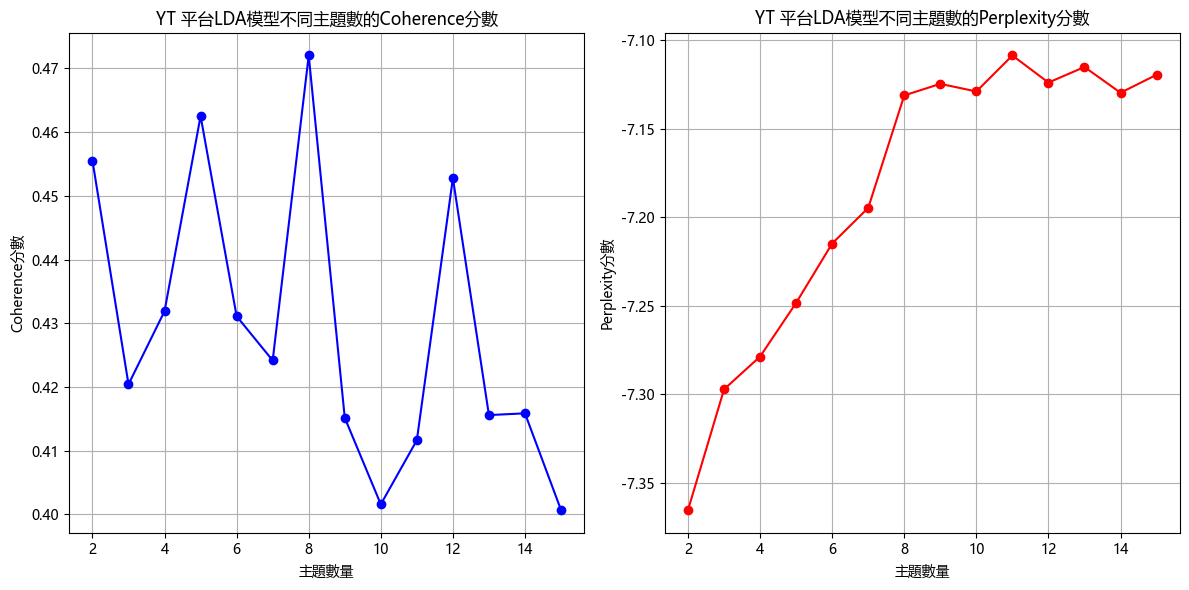

2025-06-09 22:29:27,184 : INFO : topic #0 (0.125): 0.032*"新聞" + 0.016*"頻道" + 0.014*"訂閱" + 0.012*"悠遊" + 0.012*"一番賞" + 0.012*"黃牛" + 0.010*"直播" + 0.009*"粉絲" + 0.008*"主播" + 0.007*"扭蛋"
2025-06-09 22:29:27,186 : INFO : topic #1 (0.125): 0.032*"扭蛋" + 0.028*"壽司" + 0.018*"日本" + 0.016*"影片" + 0.012*"介紹" + 0.010*"角色" + 0.007*"訂閱" + 0.006*"可愛" + 0.006*"分析" + 0.006*"粉絲"
2025-06-09 22:29:27,187 : INFO : topic #2 (0.125): 0.023*"娃娃" + 0.017*"新聞" + 0.015*"影片" + 0.011*"訂閱" + 0.010*"可愛" + 0.009*"閃店" + 0.009*"會員" + 0.009*"遊戲" + 0.008*"歡迎" + 0.008*"零食"
2025-06-09 22:29:27,188 : INFO : topic #3 (0.125): 0.023*"著作" + 0.015*"劉萱" + 0.012*"漫畫" + 0.011*"画像" + 0.011*"侵害" + 0.011*"合作" + 0.010*"英雄" + 0.010*"瑪麗" + 0.009*"動畫" + 0.009*"精華"
2025-06-09 22:29:27,189 : INFO : topic #4 (0.125): 0.012*"美国" + 0.011*"表示" + 0.009*"娃娃" + 0.009*"頻道" + 0.008*"訂閱" + 0.008*"迷因" + 0.008*"报道" + 0.008*"中国" + 0.007*"日本" + 0.006*"去年"
2025-06-09 22:29:27,189 : INFO : topic #5 (0.125): 0.032*"波子" + 0.028*"嗚話" + 0.018*"開箱" + 0.016*"影片" + 0


YT 平台最佳主題數量: 8, Coherence分數: 0.4720

YT 平台最佳LDA模型的主題:
主題 #0: 0.032*"新聞" + 0.016*"頻道" + 0.014*"訂閱" + 0.012*"悠遊" + 0.012*"一番賞" + 0.012*"黃牛" + 0.010*"直播" + 0.009*"粉絲" + 0.008*"主播" + 0.007*"扭蛋"
主題 #1: 0.032*"扭蛋" + 0.028*"壽司" + 0.018*"日本" + 0.016*"影片" + 0.012*"介紹" + 0.010*"角色" + 0.007*"訂閱" + 0.006*"可愛" + 0.006*"分析" + 0.006*"粉絲"
主題 #2: 0.023*"娃娃" + 0.017*"新聞" + 0.015*"影片" + 0.011*"訂閱" + 0.010*"可愛" + 0.009*"閃店" + 0.009*"會員" + 0.009*"遊戲" + 0.008*"歡迎" + 0.008*"零食"
主題 #3: 0.023*"著作" + 0.015*"劉萱" + 0.012*"漫畫" + 0.011*"画像" + 0.011*"侵害" + 0.011*"合作" + 0.010*"英雄" + 0.010*"瑪麗" + 0.009*"動畫" + 0.009*"精華"
主題 #4: 0.012*"美国" + 0.011*"表示" + 0.009*"娃娃" + 0.009*"頻道" + 0.008*"訂閱" + 0.008*"迷因" + 0.008*"报道" + 0.008*"中国" + 0.007*"日本" + 0.006*"去年"
主題 #5: 0.032*"波子" + 0.028*"嗚話" + 0.018*"開箱" + 0.016*"影片" + 0.015*"玩具" + 0.014*"貼圖" + 0.012*"娃娃" + 0.012*"訂閱" + 0.011*"公仔" + 0.008*"系列"
主題 #6: 0.026*"東京" + 0.021*"日本" + 0.018*"壽司" + 0.015*"聯名" + 0.010*"新聞" + 0.010*"可愛" + 0.010*"扭蛋" + 0.009*"起司" + 0.007*"推出" + 0.007*"蛋姬"

2025-06-09 22:29:28,427 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2025-06-09 22:29:28,498 : INFO : built Dictionary<10966 unique tokens: ['一塊', '不算', '之銘言', '供品', '光環']...> from 850 documents (total 49583 corpus positions)
2025-06-09 22:29:28,507 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<10966 unique tokens: ['一塊', '不算', '之銘言', '供品', '光環']...> from 850 documents (total 49583 corpus positions)", 'datetime': '2025-06-09T22:29:28.507074', 'gensim': '4.2.0', 'python': '3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:35:01) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'created'}
2025-06-09 22:29:28,520 : INFO : discarding 6407 tokens: [('再試一次', 1), ('得救', 1), ('比喻', 1), ('碎開', 1), ('簡潔', 1), ('變回', 1), ('輕柔', 1), ('依序', 1), ('連沒', 1), ('又夾', 1)]...
2025-06-09 22:29:28,521 : INFO : keeping 4559 tokens which were in no less than 2 and no more than 680 (=80.0%) documents
2025-06-09 22:29:28,528 : INFO : re

PTT 平台有效資料筆數: 850
PTT 平台原始字典大小: 10966
PTT 平台過濾後字典大小: 4559

開始 PTT 平台的主題數量評估，範圍: 2 到 15
訓練 PTT 平台 2 個主題的LDA模型...


2025-06-09 22:29:30,628 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #850/850, outstanding queue size 1
2025-06-09 22:29:31,319 : INFO : topic #0 (0.500): 0.033*"吉伊卡哇" + 0.009*"兔兔" + 0.009*"高雄" + 0.008*"小八貓" + 0.007*"日本" + 0.007*"商品" + 0.006*"可愛" + 0.006*"活動" + 0.005*"看到" + 0.004*"新聞"
2025-06-09 22:29:31,321 : INFO : topic #1 (0.500): 0.042*"吉伊卡哇" + 0.010*"商品" + 0.009*"高雄" + 0.008*"小八貓" + 0.006*"兔兔" + 0.005*"可愛" + 0.005*"日本" + 0.005*"看到" + 0.004*"代買" + 0.004*"代購"
2025-06-09 22:29:31,322 : INFO : topic diff=0.873101, rho=1.000000
2025-06-09 22:29:31,996 : INFO : -7.712 per-word bound, 209.6 perplexity estimate based on a held-out corpus of 850 documents with 42378 words
2025-06-09 22:29:31,998 : INFO : PROGRESS: pass 1, dispatched chunk #0 = documents up to #850/850, outstanding queue size 1
2025-06-09 22:29:32,551 : INFO : topic #0 (0.500): 0.036*"吉伊卡哇" + 0.010*"高雄" + 0.010*"兔兔" + 0.009*"小八貓" + 0.007*"可愛" + 0.007*"日本" + 0.006*"活動" + 0.005*"新聞" + 0.004*"看到" + 0.004*"

主題數量: 2, Coherence: 0.3278, Perplexity: -7.5028
訓練 PTT 平台 3 個主題的LDA模型...


2025-06-09 22:29:53,689 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #850/850, outstanding queue size 1
2025-06-09 22:29:54,327 : INFO : topic #0 (0.333): 0.019*"吉伊卡哇" + 0.008*"高雄" + 0.007*"商品" + 0.007*"日本" + 0.006*"新聞" + 0.006*"活動" + 0.005*"記者" + 0.005*"完整" + 0.005*"小八貓" + 0.005*"代買"
2025-06-09 22:29:54,328 : INFO : topic #1 (0.333): 0.025*"吉伊卡哇" + 0.011*"商品" + 0.007*"高雄" + 0.006*"代買" + 0.005*"代購" + 0.005*"知道" + 0.005*"日本" + 0.005*"小八貓" + 0.004*"新聞" + 0.004*"台灣"
2025-06-09 22:29:54,329 : INFO : topic #2 (0.333): 0.054*"吉伊卡哇" + 0.011*"兔兔" + 0.011*"小八貓" + 0.010*"高雄" + 0.008*"可愛" + 0.007*"商品" + 0.006*"日本" + 0.006*"看到" + 0.005*"活動" + 0.004*"真的"
2025-06-09 22:29:54,330 : INFO : topic diff=1.080960, rho=1.000000
2025-06-09 22:29:54,770 : INFO : -7.753 per-word bound, 215.6 perplexity estimate based on a held-out corpus of 850 documents with 42378 words
2025-06-09 22:29:54,771 : INFO : PROGRESS: pass 1, dispatched chunk #0 = documents up to #850/850, outstanding queue siz

主題數量: 3, Coherence: 0.5973, Perplexity: -7.3965
訓練 PTT 平台 4 個主題的LDA模型...


2025-06-09 22:30:14,340 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #850/850, outstanding queue size 1
2025-06-09 22:30:14,889 : INFO : topic #0 (0.250): 0.018*"吉伊卡哇" + 0.009*"高雄" + 0.007*"新聞" + 0.007*"記者" + 0.007*"日本" + 0.006*"完整" + 0.006*"商品" + 0.005*"活動" + 0.005*"動畫" + 0.005*"媒體"
2025-06-09 22:30:14,890 : INFO : topic #1 (0.250): 0.024*"吉伊卡哇" + 0.010*"商品" + 0.007*"高雄" + 0.006*"知道" + 0.005*"代購" + 0.005*"新聞" + 0.005*"代買" + 0.004*"日本" + 0.004*"完整" + 0.004*"看到"
2025-06-09 22:30:14,891 : INFO : topic #2 (0.250): 0.057*"吉伊卡哇" + 0.011*"小八貓" + 0.011*"兔兔" + 0.011*"高雄" + 0.008*"可愛" + 0.006*"商品" + 0.006*"日本" + 0.006*"看到" + 0.004*"活動" + 0.004*"真的"
2025-06-09 22:30:14,892 : INFO : topic #3 (0.250): 0.033*"吉伊卡哇" + 0.012*"商品" + 0.009*"小八貓" + 0.007*"兔兔" + 0.007*"日本" + 0.007*"高雄" + 0.007*"代買" + 0.005*"活動" + 0.005*"可愛" + 0.005*"台灣"
2025-06-09 22:30:14,892 : INFO : topic diff=1.344094, rho=1.000000
2025-06-09 22:30:15,312 : INFO : -7.812 per-word bound, 224.7 perplexity estimate b

主題數量: 4, Coherence: 0.5587, Perplexity: -7.3457
訓練 PTT 平台 5 個主題的LDA模型...


2025-06-09 22:30:35,073 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #850/850, outstanding queue size 1
2025-06-09 22:30:35,623 : INFO : topic #0 (0.200): 0.017*"吉伊卡哇" + 0.009*"高雄" + 0.008*"記者" + 0.008*"新聞" + 0.007*"完整" + 0.006*"日本" + 0.006*"商品" + 0.005*"媒體" + 0.005*"活動" + 0.005*"漫畫"
2025-06-09 22:30:35,624 : INFO : topic #1 (0.200): 0.024*"吉伊卡哇" + 0.010*"商品" + 0.007*"高雄" + 0.005*"知道" + 0.005*"代買" + 0.005*"代購" + 0.005*"新聞" + 0.004*"日本" + 0.004*"看到" + 0.004*"完整"
2025-06-09 22:30:35,626 : INFO : topic #2 (0.200): 0.060*"吉伊卡哇" + 0.012*"高雄" + 0.011*"小八貓" + 0.010*"兔兔" + 0.008*"可愛" + 0.006*"看到" + 0.006*"商品" + 0.006*"日本" + 0.005*"真的" + 0.005*"活動"
2025-06-09 22:30:35,627 : INFO : topic #3 (0.200): 0.032*"吉伊卡哇" + 0.013*"商品" + 0.009*"小八貓" + 0.008*"代買" + 0.007*"日本" + 0.006*"兔兔" + 0.006*"高雄" + 0.005*"台灣" + 0.005*"代購" + 0.005*"可愛"
2025-06-09 22:30:35,628 : INFO : topic #4 (0.200): 0.032*"吉伊卡哇" + 0.012*"兔兔" + 0.008*"高雄" + 0.007*"日本" + 0.007*"小八貓" + 0.006*"商品" + 0.006*"可愛" + 0.005

主題數量: 5, Coherence: 0.5537, Perplexity: -7.3361
訓練 PTT 平台 6 個主題的LDA模型...


2025-06-09 22:30:56,071 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #850/850, outstanding queue size 1
2025-06-09 22:30:56,709 : INFO : topic #3 (0.167): 0.033*"吉伊卡哇" + 0.014*"商品" + 0.009*"小八貓" + 0.008*"代買" + 0.007*"日本" + 0.006*"高雄" + 0.006*"兔兔" + 0.005*"代購" + 0.005*"台灣" + 0.005*"可愛"
2025-06-09 22:30:56,710 : INFO : topic #4 (0.167): 0.033*"吉伊卡哇" + 0.013*"兔兔" + 0.009*"高雄" + 0.007*"日本" + 0.007*"小八貓" + 0.006*"可愛" + 0.005*"商品" + 0.005*"新聞" + 0.005*"知道" + 0.004*"完整"
2025-06-09 22:30:56,711 : INFO : topic #2 (0.167): 0.062*"吉伊卡哇" + 0.013*"高雄" + 0.012*"小八貓" + 0.010*"兔兔" + 0.008*"可愛" + 0.007*"日本" + 0.006*"商品" + 0.006*"看到" + 0.005*"活動" + 0.004*"真的"
2025-06-09 22:30:56,712 : INFO : topic #5 (0.167): 0.025*"吉伊卡哇" + 0.008*"商品" + 0.006*"可愛" + 0.006*"壽司" + 0.006*"活動" + 0.006*"兔兔" + 0.005*"真的" + 0.005*"高雄" + 0.005*"小八貓" + 0.005*"有人"
2025-06-09 22:30:56,713 : INFO : topic #1 (0.167): 0.025*"吉伊卡哇" + 0.011*"商品" + 0.007*"高雄" + 0.005*"代買" + 0.005*"代購" + 0.005*"知道" + 0.004*"新聞" + 0.00

主題數量: 6, Coherence: 0.5082, Perplexity: -7.3288
訓練 PTT 平台 7 個主題的LDA模型...


2025-06-09 22:31:16,640 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #850/850, outstanding queue size 1
2025-06-09 22:31:17,155 : INFO : topic #5 (0.143): 0.025*"吉伊卡哇" + 0.008*"商品" + 0.007*"壽司" + 0.007*"活動" + 0.006*"可愛" + 0.005*"真的" + 0.005*"兔兔" + 0.005*"日本" + 0.005*"高雄" + 0.004*"有人"
2025-06-09 22:31:17,156 : INFO : topic #2 (0.143): 0.066*"吉伊卡哇" + 0.012*"小八貓" + 0.011*"高雄" + 0.010*"兔兔" + 0.009*"可愛" + 0.007*"日本" + 0.007*"看到" + 0.006*"商品" + 0.005*"喜歡" + 0.004*"真的"
2025-06-09 22:31:17,156 : INFO : topic #0 (0.143): 0.019*"吉伊卡哇" + 0.011*"新聞" + 0.011*"記者" + 0.010*"高雄" + 0.009*"完整" + 0.007*"媒體" + 0.007*"來源" + 0.006*"日本" + 0.006*"動畫" + 0.006*"漫畫"
2025-06-09 22:31:17,158 : INFO : topic #6 (0.143): 0.019*"吉伊卡哇" + 0.012*"商品" + 0.011*"高雄" + 0.010*"兔兔" + 0.006*"小八貓" + 0.005*"代購" + 0.005*"活動" + 0.004*"現場" + 0.004*"價格" + 0.004*"可愛"
2025-06-09 22:31:17,159 : INFO : topic #4 (0.143): 0.034*"吉伊卡哇" + 0.011*"兔兔" + 0.008*"高雄" + 0.008*"日本" + 0.007*"小八貓" + 0.006*"知道" + 0.006*"可愛" + 0.005

主題數量: 7, Coherence: 0.5010, Perplexity: -7.3506
訓練 PTT 平台 8 個主題的LDA模型...


2025-06-09 22:31:37,476 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #850/850, outstanding queue size 1
2025-06-09 22:31:38,006 : INFO : topic #7 (0.125): 0.036*"吉伊卡哇" + 0.010*"台灣" + 0.009*"小八貓" + 0.007*"高雄" + 0.006*"兔兔" + 0.006*"日本" + 0.006*"商品" + 0.005*"新聞" + 0.005*"知道" + 0.004*"看到"
2025-06-09 22:31:38,007 : INFO : topic #3 (0.125): 0.033*"吉伊卡哇" + 0.015*"商品" + 0.009*"小八貓" + 0.009*"代買" + 0.008*"日本" + 0.007*"兔兔" + 0.006*"高雄" + 0.005*"活動" + 0.005*"代購" + 0.005*"可愛"
2025-06-09 22:31:38,007 : INFO : topic #6 (0.125): 0.018*"吉伊卡哇" + 0.013*"高雄" + 0.012*"商品" + 0.009*"兔兔" + 0.006*"代購" + 0.005*"現場" + 0.005*"活動" + 0.005*"小八貓" + 0.005*"排隊" + 0.004*"價格"
2025-06-09 22:31:38,009 : INFO : topic #0 (0.125): 0.018*"吉伊卡哇" + 0.011*"記者" + 0.010*"新聞" + 0.010*"高雄" + 0.009*"完整" + 0.007*"媒體" + 0.006*"來源" + 0.006*"日本" + 0.006*"動畫" + 0.006*"編輯"
2025-06-09 22:31:38,010 : INFO : topic #5 (0.125): 0.026*"吉伊卡哇" + 0.007*"可愛" + 0.007*"壽司" + 0.007*"活動" + 0.007*"商品" + 0.006*"真的" + 0.006*"兔兔" + 0.005

主題數量: 8, Coherence: 0.4363, Perplexity: -7.3924
訓練 PTT 平台 9 個主題的LDA模型...


2025-06-09 22:31:58,253 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #850/850, outstanding queue size 1
2025-06-09 22:31:58,782 : INFO : topic #8 (0.111): 0.032*"吉伊卡哇" + 0.013*"商品" + 0.012*"小八貓" + 0.007*"代買" + 0.007*"看到" + 0.006*"兔兔" + 0.006*"可愛" + 0.006*"動畫" + 0.006*"日本" + 0.005*"代購"
2025-06-09 22:31:58,783 : INFO : topic #3 (0.111): 0.034*"吉伊卡哇" + 0.015*"商品" + 0.009*"代買" + 0.008*"小八貓" + 0.008*"日本" + 0.007*"高雄" + 0.006*"可愛" + 0.006*"兔兔" + 0.006*"代購" + 0.005*"活動"
2025-06-09 22:31:58,784 : INFO : topic #5 (0.111): 0.026*"吉伊卡哇" + 0.010*"壽司" + 0.007*"真的" + 0.007*"兔兔" + 0.006*"活動" + 0.006*"商品" + 0.005*"有人" + 0.005*"可愛" + 0.005*"看到" + 0.005*"粉絲"
2025-06-09 22:31:58,784 : INFO : topic #4 (0.111): 0.035*"吉伊卡哇" + 0.012*"兔兔" + 0.009*"日本" + 0.008*"高雄" + 0.008*"小八貓" + 0.007*"可愛" + 0.006*"知道" + 0.005*"新聞" + 0.005*"完整" + 0.005*"商品"
2025-06-09 22:31:58,786 : INFO : topic #1 (0.111): 0.024*"吉伊卡哇" + 0.011*"商品" + 0.006*"高雄" + 0.006*"知道" + 0.006*"代購" + 0.005*"看到" + 0.005*"警方" + 0.004

主題數量: 9, Coherence: 0.4609, Perplexity: -7.3972
訓練 PTT 平台 10 個主題的LDA模型...


2025-06-09 22:32:19,492 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #850/850, outstanding queue size 1
2025-06-09 22:32:20,017 : INFO : topic #1 (0.100): 0.025*"吉伊卡哇" + 0.011*"商品" + 0.006*"高雄" + 0.006*"知道" + 0.005*"代購" + 0.005*"看到" + 0.005*"代買" + 0.005*"盜版" + 0.005*"閃店" + 0.005*"警方"
2025-06-09 22:32:20,018 : INFO : topic #9 (0.100): 0.045*"吉伊卡哇" + 0.023*"兔兔" + 0.022*"小八貓" + 0.014*"高雄" + 0.007*"商品" + 0.007*"可愛" + 0.004*"日本" + 0.004*"燈會" + 0.004*"提燈" + 0.004*"完整"
2025-06-09 22:32:20,019 : INFO : topic #2 (0.100): 0.066*"吉伊卡哇" + 0.012*"高雄" + 0.010*"小八貓" + 0.009*"可愛" + 0.007*"兔兔" + 0.007*"日本" + 0.006*"看到" + 0.006*"商品" + 0.006*"真的" + 0.005*"活動"
2025-06-09 22:32:20,020 : INFO : topic #7 (0.100): 0.038*"吉伊卡哇" + 0.010*"台灣" + 0.008*"高雄" + 0.007*"小八貓" + 0.006*"新聞" + 0.006*"兔兔" + 0.006*"日本" + 0.005*"商品" + 0.004*"水桶" + 0.004*"燈會"
2025-06-09 22:32:20,021 : INFO : topic #8 (0.100): 0.028*"吉伊卡哇" + 0.014*"商品" + 0.009*"小八貓" + 0.008*"看到" + 0.008*"代買" + 0.007*"動畫" + 0.007*"日本" + 0.00

主題數量: 10, Coherence: 0.4920, Perplexity: -7.3773
訓練 PTT 平台 11 個主題的LDA模型...


2025-06-09 22:32:40,575 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #850/850, outstanding queue size 1
2025-06-09 22:32:41,092 : INFO : topic #2 (0.091): 0.068*"吉伊卡哇" + 0.012*"高雄" + 0.009*"小八貓" + 0.009*"可愛" + 0.008*"日本" + 0.007*"看到" + 0.006*"兔兔" + 0.006*"商品" + 0.005*"喜歡" + 0.005*"真的"
2025-06-09 22:32:41,093 : INFO : topic #7 (0.091): 0.039*"吉伊卡哇" + 0.011*"台灣" + 0.008*"小八貓" + 0.006*"知道" + 0.006*"高雄" + 0.006*"兔兔" + 0.006*"日本" + 0.005*"看到" + 0.005*"睡衣派對" + 0.004*"燈會"
2025-06-09 22:32:41,093 : INFO : topic #1 (0.091): 0.023*"吉伊卡哇" + 0.009*"商品" + 0.007*"知道" + 0.005*"代購" + 0.005*"看到" + 0.005*"日本" + 0.005*"警方" + 0.005*"真的" + 0.005*"高雄" + 0.004*"代買"
2025-06-09 22:32:41,094 : INFO : topic #9 (0.091): 0.044*"吉伊卡哇" + 0.031*"兔兔" + 0.023*"小八貓" + 0.011*"高雄" + 0.008*"可愛" + 0.006*"商品" + 0.005*"覺得" + 0.004*"台灣" + 0.004*"日本" + 0.004*"提燈"
2025-06-09 22:32:41,095 : INFO : topic #8 (0.091): 0.027*"吉伊卡哇" + 0.015*"商品" + 0.010*"小八貓" + 0.009*"代買" + 0.008*"看到" + 0.007*"動畫" + 0.006*"可愛" + 0.

主題數量: 11, Coherence: 0.3884, Perplexity: -7.3565
訓練 PTT 平台 12 個主題的LDA模型...


2025-06-09 22:33:01,299 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #850/850, outstanding queue size 1
2025-06-09 22:33:01,812 : INFO : topic #2 (0.083): 0.065*"吉伊卡哇" + 0.011*"小八貓" + 0.010*"可愛" + 0.007*"兔兔" + 0.007*"高雄" + 0.007*"日本" + 0.006*"看到" + 0.006*"商品" + 0.005*"真的" + 0.005*"喜歡"
2025-06-09 22:33:01,812 : INFO : topic #4 (0.083): 0.031*"吉伊卡哇" + 0.008*"日本" + 0.007*"可愛" + 0.007*"兔兔" + 0.006*"知道" + 0.006*"真的" + 0.005*"商品" + 0.005*"高雄" + 0.005*"小八貓" + 0.004*"新聞"
2025-06-09 22:33:01,813 : INFO : topic #8 (0.083): 0.027*"吉伊卡哇" + 0.017*"商品" + 0.012*"小八貓" + 0.010*"代買" + 0.007*"動畫" + 0.007*"代購" + 0.006*"看到" + 0.006*"日本" + 0.005*"兔兔" + 0.005*"匯率"
2025-06-09 22:33:01,814 : INFO : topic #5 (0.083): 0.024*"吉伊卡哇" + 0.010*"可愛" + 0.008*"壽司" + 0.006*"真的" + 0.006*"活動" + 0.005*"商品" + 0.005*"動畫" + 0.005*"有人" + 0.005*"看到" + 0.005*"睡衣派對"
2025-06-09 22:33:01,814 : INFO : topic #7 (0.083): 0.035*"吉伊卡哇" + 0.011*"台灣" + 0.009*"小八貓" + 0.006*"商品" + 0.006*"知道" + 0.006*"兔兔" + 0.006*"問卦" + 0.

主題數量: 12, Coherence: 0.4290, Perplexity: -7.3436
訓練 PTT 平台 13 個主題的LDA模型...


2025-06-09 22:33:23,198 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #850/850, outstanding queue size 1
2025-06-09 22:33:23,720 : INFO : topic #8 (0.077): 0.025*"吉伊卡哇" + 0.016*"商品" + 0.009*"小八貓" + 0.009*"代買" + 0.008*"動畫" + 0.008*"看到" + 0.006*"代購" + 0.005*"運費" + 0.005*"匯率" + 0.005*"電視"
2025-06-09 22:33:23,721 : INFO : topic #6 (0.077): 0.014*"吉伊卡哇" + 0.014*"商品" + 0.008*"代購" + 0.008*"高雄" + 0.006*"兔兔" + 0.005*"現場" + 0.005*"價格" + 0.004*"購買" + 0.004*"主角" + 0.004*"直接"
2025-06-09 22:33:23,722 : INFO : topic #10 (0.077): 0.031*"吉伊卡哇" + 0.012*"高雄" + 0.011*"商品" + 0.010*"新聞" + 0.009*"完整" + 0.008*"活動" + 0.008*"記者" + 0.008*"媒體" + 0.007*"來源" + 0.006*"日本"
2025-06-09 22:33:23,723 : INFO : topic #4 (0.077): 0.034*"吉伊卡哇" + 0.009*"知道" + 0.009*"日本" + 0.008*"兔兔" + 0.006*"小八貓" + 0.005*"商品" + 0.005*"可愛" + 0.005*"覺得" + 0.005*"台灣" + 0.005*"高雄"
2025-06-09 22:33:23,723 : INFO : topic #11 (0.077): 0.050*"吉伊卡哇" + 0.017*"高雄" + 0.008*"日本" + 0.007*"可愛" + 0.007*"商品" + 0.006*"看到" + 0.006*"活動" + 0.00

主題數量: 13, Coherence: 0.4237, Perplexity: -7.3511
訓練 PTT 平台 14 個主題的LDA模型...


2025-06-09 22:33:45,770 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #850/850, outstanding queue size 1
2025-06-09 22:33:46,281 : INFO : topic #7 (0.071): 0.032*"吉伊卡哇" + 0.011*"台灣" + 0.007*"小八貓" + 0.006*"知道" + 0.006*"問卦" + 0.005*"兔兔" + 0.005*"燈會" + 0.005*"日本" + 0.005*"水桶" + 0.005*"商品"
2025-06-09 22:33:46,282 : INFO : topic #2 (0.071): 0.066*"吉伊卡哇" + 0.012*"小八貓" + 0.009*"兔兔" + 0.008*"高雄" + 0.008*"可愛" + 0.007*"喜歡" + 0.006*"日本" + 0.006*"商品" + 0.005*"看到" + 0.005*"真的"
2025-06-09 22:33:46,283 : INFO : topic #11 (0.071): 0.049*"吉伊卡哇" + 0.018*"高雄" + 0.008*"日本" + 0.007*"商品" + 0.007*"可愛" + 0.005*"看到" + 0.005*"活動" + 0.005*"提燈" + 0.005*"遊樂園" + 0.005*"冬日"
2025-06-09 22:33:46,284 : INFO : topic #4 (0.071): 0.029*"吉伊卡哇" + 0.011*"知道" + 0.009*"兔兔" + 0.009*"日本" + 0.006*"可愛" + 0.006*"小八貓" + 0.006*"真的" + 0.005*"台灣" + 0.005*"商品" + 0.004*"覺得"
2025-06-09 22:33:46,284 : INFO : topic #8 (0.071): 0.023*"吉伊卡哇" + 0.016*"商品" + 0.011*"小八貓" + 0.008*"代買" + 0.007*"動畫" + 0.006*"可愛" + 0.005*"日本" + 0.

主題數量: 14, Coherence: 0.3741, Perplexity: -7.3814
訓練 PTT 平台 15 個主題的LDA模型...


2025-06-09 22:34:07,008 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #850/850, outstanding queue size 1
2025-06-09 22:34:07,560 : INFO : topic #12 (0.067): 0.021*"吉伊卡哇" + 0.010*"新聞" + 0.008*"可愛" + 0.007*"完整" + 0.007*"記者" + 0.006*"編輯" + 0.006*"作者" + 0.006*"媒體" + 0.006*"來源" + 0.006*"東西"
2025-06-09 22:34:07,562 : INFO : topic #11 (0.067): 0.052*"吉伊卡哇" + 0.020*"高雄" + 0.008*"日本" + 0.007*"商品" + 0.006*"可愛" + 0.006*"看到" + 0.006*"提燈" + 0.005*"新聞" + 0.005*"兔兔" + 0.005*"台灣"
2025-06-09 22:34:07,562 : INFO : topic #8 (0.067): 0.025*"吉伊卡哇" + 0.016*"商品" + 0.009*"小八貓" + 0.009*"代買" + 0.006*"代購" + 0.006*"電視" + 0.005*"看到" + 0.005*"動畫" + 0.005*"匯率" + 0.005*"廣告"
2025-06-09 22:34:07,563 : INFO : topic #3 (0.067): 0.028*"吉伊卡哇" + 0.020*"商品" + 0.012*"代買" + 0.007*"代購" + 0.007*"日本" + 0.007*"小八貓" + 0.006*"運費" + 0.006*"面交" + 0.005*"購入" + 0.005*"兔兔"
2025-06-09 22:34:07,564 : INFO : topic #5 (0.067): 0.023*"吉伊卡哇" + 0.009*"真的" + 0.007*"壽司" + 0.006*"可愛" + 0.006*"商品" + 0.005*"屍塊" + 0.005*"活動" + 0.00

主題數量: 15, Coherence: 0.3824, Perplexity: -7.3804
PTT 平台LDA模型訓練和評估完成，耗時: 297.18秒


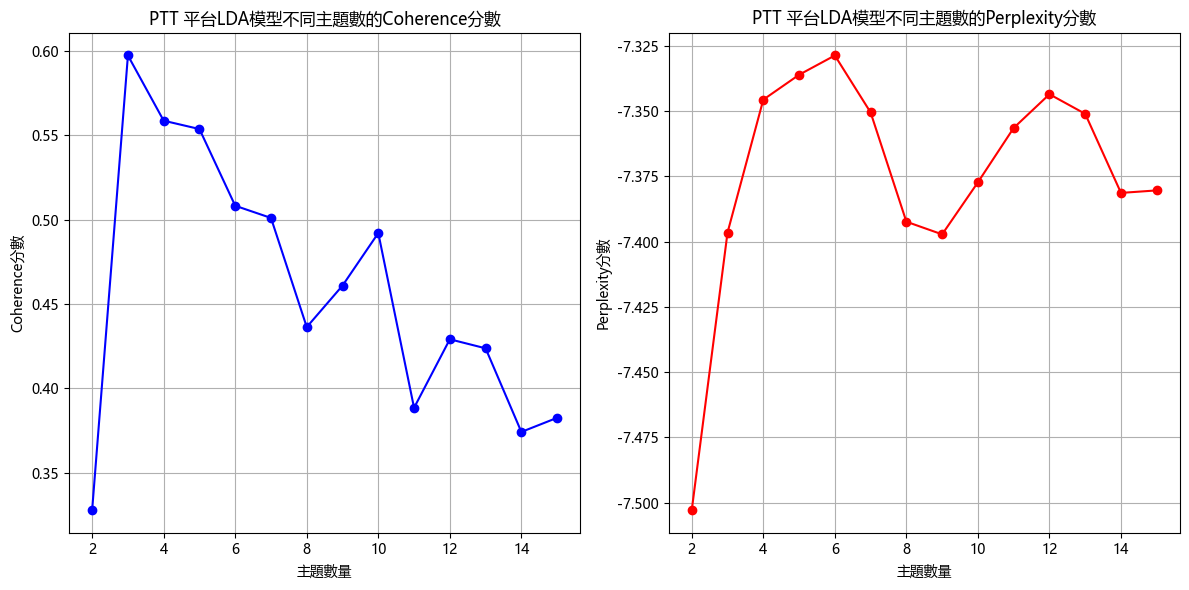

2025-06-09 22:34:26,611 : INFO : topic #0 (0.333): 0.029*"吉伊卡哇" + 0.020*"高雄" + 0.012*"新聞" + 0.010*"完整" + 0.010*"活動" + 0.009*"燈會" + 0.008*"記者" + 0.008*"媒體" + 0.008*"提燈" + 0.007*"冬日"
2025-06-09 22:34:26,613 : INFO : topic #1 (0.333): 0.026*"商品" + 0.015*"代買" + 0.014*"代購" + 0.011*"吉伊卡哇" + 0.009*"運費" + 0.009*"價格" + 0.008*"面交" + 0.008*"購入" + 0.006*"購買" + 0.006*"匯率"
2025-06-09 22:34:26,613 : INFO : topic #2 (0.333): 0.057*"吉伊卡哇" + 0.016*"小八貓" + 0.015*"兔兔" + 0.010*"可愛" + 0.008*"看到" + 0.007*"日本" + 0.006*"高雄" + 0.006*"真的" + 0.006*"知道" + 0.005*"動畫"



PTT 平台最佳主題數量: 3, Coherence分數: 0.5973

PTT 平台最佳LDA模型的主題:
主題 #0: 0.029*"吉伊卡哇" + 0.020*"高雄" + 0.012*"新聞" + 0.010*"完整" + 0.010*"活動" + 0.009*"燈會" + 0.008*"記者" + 0.008*"媒體" + 0.008*"提燈" + 0.007*"冬日"
主題 #1: 0.026*"商品" + 0.015*"代買" + 0.014*"代購" + 0.011*"吉伊卡哇" + 0.009*"運費" + 0.009*"價格" + 0.008*"面交" + 0.008*"購入" + 0.006*"購買" + 0.006*"匯率"
主題 #2: 0.057*"吉伊卡哇" + 0.016*"小八貓" + 0.015*"兔兔" + 0.010*"可愛" + 0.008*"看到" + 0.007*"日本" + 0.006*"高雄" + 0.006*"真的" + 0.006*"知道" + 0.005*"動畫"


In [6]:
# 分別處理三個平台的資料並進行主題數量評估
platforms = ['IG', 'YT', 'PTT']
platform_analysis_results = {}

for platform in platforms:
    print(f"\n{'='*50}")
    print(f"處理 {platform} 平台資料 - 主題數量評估")
    print(f"{'='*50}")
    
    # 篩選該平台的資料
    df_platform = df[df['dataSource'] == platform].copy()
    print(f"{platform} 平台原始資料筆數: {len(df_platform)}")
    
    if len(df_platform) == 0:
        print(f"警告: {platform} 平台無資料，跳過處理")
        continue
    
    # 文本預處理
    df_platform['tokenized_text'] = df_platform['artContent'].apply(preprocess_text)
    
    # 只保留非空的文本
    df_platform = df_platform[df_platform['tokenized_text'].map(len) > 0]
    print(f"{platform} 平台有效資料筆數: {len(df_platform)}")
    
    if len(df_platform) < 20:  # 設定最少需要20筆資料才進行分析
        print(f"警告: {platform} 平台有效資料太少，跳過LDA分析")
        continue
    
    # 創建字典
    dictionary_platform = Dictionary(df_platform['tokenized_text'])
    print(f"{platform} 平台原始字典大小: {len(dictionary_platform)}")
    
    # 過濾極端頻率的詞
    dictionary_platform.filter_extremes(no_below=2, no_above=0.8)
    print(f"{platform} 平台過濾後字典大小: {len(dictionary_platform)}")
    
    # 創建詞袋模型
    corpus_platform = [dictionary_platform.doc2bow(text) for text in df_platform['tokenized_text']]
    
    # 設定主題數量範圍進行評估
    max_topics = min(15, len(df_platform) // 10)  # 根據資料量動態調整最大主題數
    topic_range = range(2, max_topics + 1, 1)  # 從2開始，步長為1
    coherence_scores = []
    perplexity_scores = []
    models = []
    
    print(f"\n開始 {platform} 平台的主題數量評估，範圍: {min(topic_range)} 到 {max(topic_range)}")
    
    start = time.time()
    for num_topics in topic_range:
        print(f"訓練 {platform} 平台 {num_topics} 個主題的LDA模型...")
        
        # 訓練LDA模型
        lda_model = LdaMulticore(
            corpus=corpus_platform,
            id2word=dictionary_platform,
            num_topics=num_topics,
            workers=2,  # 使用多核心加速
            passes=10,  # 迭代次數
            random_state=42
        )
        
        # 計算coherence分數
        coherence_model = CoherenceModel(
            model=lda_model, 
            texts=df_platform['tokenized_text'], 
            dictionary=dictionary_platform, 
            coherence='c_v'
        )
        coherence = coherence_model.get_coherence()
        coherence_scores.append(coherence)
        
        # 計算perplexity分數
        perplexity = lda_model.log_perplexity(corpus_platform)
        perplexity_scores.append(perplexity)
        
        models.append(lda_model)
        
        print(f"主題數量: {num_topics}, Coherence: {coherence:.4f}, Perplexity: {perplexity:.4f}")
    
    end = time.time()
    print(f"{platform} 平台LDA模型訓練和評估完成，耗時: {end - start:.2f}秒")
    
    # 繪製coherence分數的變化圖
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(topic_range, coherence_scores, 'o-', color='blue')
    plt.title(f'{platform} 平台LDA模型不同主題數的Coherence分數')
    plt.xlabel('主題數量')
    plt.ylabel('Coherence分數')
    plt.grid(True)
    
    # 繪製perplexity分數的變化圖
    plt.subplot(1, 2, 2)
    plt.plot(topic_range, perplexity_scores, 'o-', color='red')
    plt.title(f'{platform} 平台LDA模型不同主題數的Perplexity分數')
    plt.xlabel('主題數量')
    plt.ylabel('Perplexity分數')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'{platform}_topic_evaluation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 找出最佳主題數量
    best_index = coherence_scores.index(max(coherence_scores))
    best_num_topics = topic_range[best_index]
    best_model = models[best_index]
    
    print(f"\n{platform} 平台最佳主題數量: {best_num_topics}, Coherence分數: {coherence_scores[best_index]:.4f}")
    
    # 顯示最佳模型的主題
    print(f"\n{platform} 平台最佳LDA模型的主題:")
    for topic_id, topic in best_model.print_topics(num_words=10):
        print(f"主題 #{topic_id}: {topic}")
    
    # 儲存分析結果
    platform_analysis_results[platform] = {
        'df': df_platform,
        'dictionary': dictionary_platform,
        'corpus': corpus_platform,
        'topic_range': list(topic_range),
        'coherence_scores': coherence_scores,
        'perplexity_scores': perplexity_scores,
        'models': models,
        'best_num_topics': best_num_topics,
        'best_model': best_model,
        'best_coherence': coherence_scores[best_index],
        'best_perplexity': perplexity_scores[best_index]
    }

7.而我們想評估基於三個主角的Guided LDA模型分析
原先三個種子詞是設定三主角的名字跟暱稱   (註:使用縮寫是因為之前的替代詞已經建立，所以才只建立少少的種子詞)

    ['吉伊卡哇', "小可愛"],
    ['小八', "ハチワレ"],
    ['烏薩奇', '兔兔', "うさぎ"]


產出三個主題字詞如下
Topic 0	銅鑼灣、香港、購物、百貨	香港代購/購物主題 - 主要討論香港地區的購物資訊
Topic 1	可愛、蛋糕、美食、聯名	    美食/周邊商品主題 - 討論角色相關的美食或聯名商品
Topic 2	代購、門市、下單、付款	    代購服務主題 - 討論代購流程與服務

結果顯示可以看到購買相關主題還是大大的影響了主題分析，原始的資料集有許多討論皆是集中於購買身上

接著將切換至SMA_FR_BertTopic進行說明

In [26]:
# 設定種子詞
seed_topic_list = [
    ['吉伊卡哇', "小可愛"],
    ['小八', "ハチワレ"],
    ['烏薩奇', '兔兔', "うさぎ"]
]
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        if word in word2id:
            seed_topics[word2id[word]] = t_id

# 建立 GuidedLDA 模型
model = guidedlda.GuidedLDA(n_topics=3, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=0.15)

# 查看主題詞
n_top_words = 10
for i, topic_dist in enumerate(model.topic_word_):
    topic_words = [vocab[j] for j in topic_dist.argsort()[:-n_top_words-1:-1]]
    print(f"Topic {i}: {' '.join(topic_words)}")

2025-06-09 18:18:37,103 : INFO : n_documents: 12446
2025-06-09 18:18:37,107 : INFO : vocab_size: 9366
2025-06-09 18:18:37,108 : INFO : n_words: 541215
2025-06-09 18:18:37,109 : INFO : n_topics: 3
2025-06-09 18:18:37,110 : INFO : n_iter: 100
2025-06-09 18:18:37,116 : WARNING : all zero row in document-term matrix found
2025-06-09 18:18:39,805 : INFO : <0> log likelihood: -4887870
2025-06-09 18:18:40,242 : INFO : <20> log likelihood: -4010264
2025-06-09 18:18:40,659 : INFO : <40> log likelihood: -3952495
2025-06-09 18:18:41,067 : INFO : <60> log likelihood: -3925338
2025-06-09 18:18:41,476 : INFO : <80> log likelihood: -3910203
2025-06-09 18:18:41,875 : INFO : <99> log likelihood: -3901628


Topic 0: 銅鑼灣 日本 公仔 玩具 代購 精品 香港 對面 購物 百貨
Topic 1: 日本 可愛 蛋糕 小八貓 兔兔 美食 活動 壽司 角色 聯名
Topic 2: 代購 日本 兔兔 門市 公仔 小八貓 旺角 下單 八字 付款
